In [5]:
from matplotlib import pyplot as plt

plt.rcParams['axes.unicode_minus']=False

plt.rcParams['font.family'] = "simsun"

第一问第一种情况（遗传算法）

中文注释版，附录使用此版本

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any
import random

# 类型别名
Chromosome = List[List[Dict[str, Any]]]  # 染色体表示多个地块种植的方案
Population = List[Chromosome]  # 种群由多个染色体组成

# 辅助函数
# 解析价格字符串为浮点数
def parse_price(price_str: str) -> float:
    if isinstance(price_str, str) and '-' in price_str:
        min_price, max_price = map(float, price_str.split('-'))
        return (min_price + max_price) / 2
    return float(price_str)

# 根据地块类型获取每年种植季节数
def get_seasons_per_year(plot_type: str) -> int:
    if plot_type in ['平旱地', '梯田', '山坡地']:
        return 1  # 每年种一季
    elif plot_type == '水浇地':
        return 2  # 每年种两季
    elif plot_type in ['普通大棚', '智慧大棚']:
        return 2  # 每年种两季
    else:
        raise ValueError(f"未知地块类型: {plot_type}")

# 初始化种群
def initialize_population(land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]], num_years: int, population_size: int) -> Population:
    population = []
    for _ in range(population_size):
        chromosome = []  # 一个染色体对应一个种植方案
        for _, plot in land_info.iterrows():
            plot_area = plot['地块面积/亩']  # 获取地块面积
            plot_type = plot['地块类型']  # 获取地块类型
            suitable_crops = crop_suitability.get(plot_type, [])  # 获取适合的作物
            seasons_per_year = get_seasons_per_year(plot_type)  # 获取每年种植的季节数
            
            if not suitable_crops:
                raise ValueError(f"未找到适合该地块类型的作物: {plot_type}")
            
            plot_plan = []
            for _ in range(num_years):  # 为每一年创建种植方案
                year_plan = []
                for _ in range(seasons_per_year):  # 每个季节种植不同作物
                    season_plan = {'crop_id': np.random.choice(suitable_crops), 'area': plot_area}
                    year_plan.append(season_plan)
                plot_plan.append(year_plan)
            chromosome.append(plot_plan)
        
        # 初始化后应用特殊规则
        chromosome = apply_special_rules(chromosome, land_info)
        population.append(chromosome)
    return population

# 计算适应度（收益）
def calculate_fitness(chromosome: Chromosome, land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float]) -> float:
    total_revenue = 0  # 总收入
    penalty = 0  # 罚款（种植同一作物的惩罚）
    for plot_index, plot in enumerate(chromosome):
        plot_area = land_info.iloc[plot_index]['地块面积/亩']  # 地块面积
        previous_crop = None  # 记录上一季种的作物
        
        for year in plot:
            for season in year:
                crop_id = season['crop_id']  # 获取作物ID
                area = season['area']  # 种植面积
                
                if area > plot_area:
                    return float('-inf')  # 面积超限返回无效解
                
                if crop_id == 0:  # 空季节
                    continue
                
                crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                if crop_stats.empty:
                    continue
                
                crop_yield = crop_stats['亩产量/斤'].values[0]  # 获取亩产量
                crop_cost = crop_stats['种植成本/(元/亩)'].values[0]  # 获取种植成本
                crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])  # 获取作物价格
                
                demand = market_demand.get(crop_id, 0)  # 获取市场需求
                production = area * crop_yield  # 计算产量
                normal_sales = min(production, demand) * crop_price  # 正常销售收入
                excess_production = max(production - demand, 0)  # 超额生产部分
                discounted_sales = excess_production * crop_price * 0.3  # 超产部分按折扣销售
                
                revenue = normal_sales + discounted_sales - (area * crop_cost)  # 计算净收益
                total_revenue += revenue
                
                # 连续种植同一作物惩罚
                if previous_crop == crop_id:
                    penalty += 0.1 * revenue  # 连续种植同一作物惩罚10%
                previous_crop = crop_id
    
    return total_revenue - penalty  # 返回收益减去惩罚后的适应度

# 选择操作（锦标赛选择）
def selection(population: Population, fitnesses: List[float], tournament_size: int = 5) -> Population:
    selected = []
    for _ in range(len(population)):
        candidates = random.sample(range(len(population)), tournament_size)  # 随机挑选若干个个体
        winner = max(candidates, key=lambda i: fitnesses[i])  # 选择适应度最高的个体
        selected.append(population[winner])
    return selected

# 交叉操作（包含单点交叉和均匀交叉）
def crossover(parent1: Chromosome, parent2: Chromosome, crossover_rate: float) -> tuple[Chromosome, Chromosome]:
    if np.random.rand() < crossover_rate:  # 判断是否进行交叉
        child1, child2 = [], []
        for plot1, plot2 in zip(parent1, parent2):
            if np.random.rand() < 0.5:  # 50%概率选择均匀交叉
                child1_plot, child2_plot = [], []
                for year1, year2 in zip(plot1, plot2):
                    child1_year = [season1 if np.random.rand() < 0.5 else season2 for season1, season2 in zip(year1, year2)]
                    child2_year = [season2 if np.random.rand() < 0.5 else season1 for season1, season2 in zip(year1, year2)]
                    child1_plot.append(child1_year)
                    child2_plot.append(child2_year)
            else:  # 50%概率选择单点交叉
                crossover_point = np.random.randint(1, len(plot1))  # 随机选择交叉点
                child1_plot = plot1[:crossover_point] + plot2[crossover_point:]  # 交叉生成新的地块方案
                child2_plot = plot2[:crossover_point] + plot1[crossover_point:]
            child1.append(child1_plot)
            child2.append(child2_plot)
        return child1, child2
    return parent1, parent2

# 突变操作
def mutate(chromosome: Chromosome, crop_suitability: Dict[str, List[int]], land_info: pd.DataFrame, mutation_rate: float) -> Chromosome:
    for plot_index, plot in enumerate(chromosome):
        plot_type = land_info.iloc[plot_index]['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])  # 获取适合作物
        plot_area = land_info.iloc[plot_index]['地块面积/亩']  # 获取地块面积
        
        for year in plot:
            for season in year:
                if np.random.rand() < mutation_rate:  # 按概率突变作物种类
                    season['crop_id'] = np.random.choice(suitable_crops)
                if np.random.rand() < mutation_rate / 2:  # 较低概率突变种植面积
                    # 突变面积，控制在合理范围内
                    season['area'] = max(0.5 * plot_area, min(plot_area, season['area'] + np.random.normal(0, 0.1 * plot_area)))
    return chromosome

# 强制土地适应性检查
def enforce_land_suitability(chromosome: Chromosome, land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]]) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])  # 获取适合的作物
        plot_area = plot_info['地块面积/亩']
        
        if not suitable_crops:
            raise ValueError(f"未找到适合该地块类型的作物: {plot_type}")
        
        for year in chromosome[plot_index]:
            for season in year:
                if season['crop_id'] not in suitable_crops:  # 确保种植的作物适应土地
                    season['crop_id'] = np.random.choice(suitable_crops)
                season['area'] = plot_area  # 强制使用全部面积
    
    return chromosome

# 应用特殊规则
def apply_special_rules(chromosome: Chromosome, land_info: pd.DataFrame) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        plot_area = plot_info['地块面积/亩']
        
        # 针对水浇地的特殊种植规则
        if plot_type == '水浇地':
            for year in chromosome[plot_index]:
                if np.random.rand() < 0.5:
                    # 第一季种植水稻
                    year[0] = {'crop_id': 16, 'area': plot_area}
                    # 第二季空种植
                    year[1] = {'crop_id': 0, 'area': 0}
                else:
                    # 两季种植蔬菜
                    vegetable_ids = [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
                    year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                    year[1] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
        
        # 针对大棚的特殊种植规则
        elif plot_type in ['普通大棚', '智慧大棚']:
            vegetable_ids = [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33]
            mushroom_ids = [38, 39, 40, 41]
            for year in chromosome[plot_index]:
                year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                year[1] = {'crop_id': np.random.choice(mushroom_ids), 'area': plot_area}
    
    return chromosome

# 主循环 - 遗传算法
import matplotlib.pyplot as plt

# 遗传算法主循环，带有适应度跟踪
def genetic_algorithm(land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float], 
                      crop_suitability: Dict[str, List[int]], num_years: int,
                      population_size: int, max_generations: int, crossover_rate: float, mutation_rate: float) -> Chromosome:
    # 初始化种群
    population = initialize_population(land_info, crop_suitability, num_years, population_size)
    
    best_solution = None  # 最优解
    best_fitness = float('-inf')  # 最佳适应度
    fitness_over_time = []  # 记录适应度随时间变化
    generations_without_improvement = 0  # 无改进的代数计数
    
    for generation in range(max_generations):
        # 计算每个个体的适应度
        fitnesses = [calculate_fitness(chrom, land_info, statistics_2023, market_demand) for chrom in population]
        
        max_fitness = max(fitnesses)
        fitness_over_time.append(max_fitness)
        
        # 更新最佳适应度和方案
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_solution = population[np.argmax(fitnesses)]
            generations_without_improvement = 0
        else:
            generations_without_improvement += 1
        
        # 如果多代未改进，停止迭代
        if generations_without_improvement > 50:
            print(f"连续50代没有改进。算法在第{generation + 1}代停止。")
            break
        
        # 选择操作
        selected = selection(population, fitnesses)
        
        # 生成新种群，保留最优个体
        new_population = [best_solution]  # 精英保留
        
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(selected, 2)
            child1, child2 = crossover(parent1, parent2, crossover_rate)  # 交叉操作
            child1 = mutate(child1, crop_suitability, land_info, mutation_rate)  # 突变操作
            child2 = mutate(child2, crop_suitability, land_info, mutation_rate)
            new_population.extend([child1, child2])
        
        # 更新种群
        population = new_population[:population_size]
        
        # 强制土地适应性和应用特殊规则
        population = [apply_special_rules(enforce_land_suitability(chrom, land_info, crop_suitability), land_info) for chrom in population]
        
        # 自适应调整突变率
        if generations_without_improvement > 10:
            mutation_rate = min(0.5, mutation_rate * 1.05)
        else:
            mutation_rate = max(0.01, mutation_rate * 0.95)
        
        print(f"第{generation + 1}代，最佳适应度: {best_fitness}，突变率: {mutation_rate:.4f}")
    
    return best_solution

# 保存结果到Excel文件
def save_result(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str]):
    crop_distribution = {crop: 0 for crop in crop_names}  # 存储各作物的总面积
    
    with pd.ExcelWriter(result_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        for year_index, year in enumerate(years):
            for season in range(2):  # 两个季节
                result_df = pd.DataFrame(columns=['地块名'] + crop_names)
                result_df['地块名'] = land_info['地块名称']
                result_df = result_df.set_index('地块名')
                
                for plot_index, plot in enumerate(best_solution):
                    plot_name = land_info.iloc[plot_index]['地块名称']
                    year_plan = plot[year_index]
                    
                    if season < len(year_plan):
                        crop_id = year_plan[season]['crop_id']
                        area = year_plan[season]['area']
                        
                        if crop_id > 0:  # 忽略空季节
                            crop_name = crop_names[crop_id - 1]  # 作物ID假设从1开始
                            if crop_name in result_df.columns:
                                result_df.at[plot_name, crop_name] = area
                            else:
                                result_df[crop_name] = 0
                                result_df.at[plot_name, crop_name] = area
                            
                            # 更新作物分布
                            crop_distribution[crop_name] += area
                
                # 删除全为0的列
                result_df = result_df.loc[:, (result_df != 0).any(axis=0)]
                
                # 重置索引，使地块名成为列
                result_df = result_df.reset_index()
                
                # 保存到Excel
                sheet_name = f"{year}_Season{season+1}"
                result_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"最优种植方案已保存到文件: {result_path}")
    
    # 绘制作物分布图
    plt.figure(figsize=(10, 6))
    plt.bar(crop_distribution.keys(), crop_distribution.values(), color='skyblue')
    plt.title('最佳种植方案中的作物分布')
    plt.xlabel('作物')
    plt.ylabel('总面积 (亩)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 保存详细结果
def save_detailed_results(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str], statistics_2023: pd.DataFrame):
    detailed_results = []
    
    for year_index, year in enumerate(years):
        for plot_index, plot in enumerate(best_solution):
            plot_name = land_info.iloc[plot_index]['地块名称']
            plot_area = land_info.iloc[plot_index]['地块面积/亩']
            
            # 遍历当年的每个季节
            for season_index, season in enumerate(plot[year_index]):  # season_index 表示第几季
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id > 0:
                    crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                    crop_name = crop_names[crop_id - 1]
                    crop_yield = crop_stats['亩产量/斤'].values[0]  # 每亩产量（斤/亩）
                    crop_cost = crop_stats['种植成本/(元/亩)'].values[0]  # 每亩成本（元/亩）
                    crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])  # 销售单价（元/斤）

                    # 计算总产量，保持斤为单位
                    total_production = area * crop_yield  # 总产量 = 种植面积 * 每亩产量

                    # 销售收入，直接以斤计算
                    sales_revenue = total_production * crop_price  # 销售收入 = 总产量 * 销售单价（元/斤）

                    # 种植成本
                    planting_cost = area * crop_cost  # 种植成本 = 种植面积 * 每亩成本

                    # 总利润
                    total_profit = sales_revenue - planting_cost  # 总利润 = 销售收入 - 种植成本

                    # 记录详细结果，增加 "季节" 字段
                    detailed_results.append({
                        '年份': year,
                        '季节': f'第{season_index + 1}季',  # season_index 从 0 开始，显示为第几季
                        '作物': crop_name,
                        '地块名': plot_name,
                        '种植面积 (亩)': area,
                        '总产量 (斤)': total_production,  # 现在以斤为单位
                        '销售收入 (元)': sales_revenue,
                        '种植成本 (元)': planting_cost,
                        '总利润 (元)': total_profit
                    })
    
    # 将结果保存为DataFrame
    detailed_results_df = pd.DataFrame(detailed_results)
    
    # 保存到Excel文件
    detailed_result_path = result_path.replace(".xlsx", "_detailed.xlsx")
    detailed_results_df.to_excel(detailed_result_path, index=False)
    
    print(f"详细结果已保存到: {detailed_result_path}")


# 主函数
def main():
    # 读取数据
    land_info = pd.read_excel("附件1.xlsx", sheet_name='乡村的现有耕地')
    statistics_2023 = pd.read_excel("附件2.xlsx", sheet_name='2023年统计的相关数据')
    
    # 清理地块类型，去掉空格
    land_info['地块类型'] = land_info['地块类型'].str.strip()
    
    # 定义参数
    result_path = "result1_1.xlsx"
    crop_suitability = {
        '平旱地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '梯田': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '山坡地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '水浇地': [16, 20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23],
        '普通大棚': [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 38, 39, 40, 41],
        '智慧大棚': [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
    }
    
    # 输出所有唯一的地块类型用于调试
    unique_plot_types = land_info['地块类型'].unique()
    print("land_info中的唯一地块类型:")
    for plot_type in unique_plot_types:
        print(f"'{plot_type}'")
    
    print("\ncrop_suitability中的地块类型:")
    for plot_type in crop_suitability.keys():
        print(f"'{plot_type}'")
    
    # 检查land_info中的所有地块类型是否在crop_suitability中都有对应条目
    for plot_type in unique_plot_types:
        if plot_type not in crop_suitability or not crop_suitability[plot_type]:
            raise ValueError(f"地块类型'{plot_type}'的作物适宜列表为空或缺失")
    
    crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
                  '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
                  '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
                  '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']
    market_demand = {
        1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
        9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
        17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
        24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
        32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0,39: 10750.0, 40: 10750.0, 41: 10750.0
    }

    
    # 遗传算法参数
    num_years = 7
    population_size = 100
    max_generations = 10
    crossover_rate = 0.8
    mutation_rate = 0.01
    
    # 需要处理的年份
    years = ['2024', '2025', '2026', '2027', '2028', '2029', '2030']

    # 运行遗传算法生成最优种植方案
    best_solution = genetic_algorithm(land_info, statistics_2023, market_demand, crop_suitability, num_years, population_size, max_generations, crossover_rate, mutation_rate)

    # 保存最优方案到Excel
    save_result(best_solution, result_path, land_info, crop_names, years)
    
    # 保存详细结果到Excel
    save_detailed_results(best_solution, result_path, land_info, crop_names, years, statistics_2023)

if __name__ == "__main__":
    main()


Unique plot types in land_info:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'

Plot types in crop_suitability:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'
Generation 1, Best fitness: 47058488.975, Mutation rate: 0.0100
Generation 2, Best fitness: 47238334.125, Mutation rate: 0.0100
Generation 3, Best fitness: 47238334.125, Mutation rate: 0.0100
Generation 4, Best fitness: 47751908.225, Mutation rate: 0.0100
Generation 5, Best fitness: 47751908.225, Mutation rate: 0.0100
Generation 6, Best fitness: 47751908.225, Mutation rate: 0.0100
Generation 7, Best fitness: 48029541.375, Mutation rate: 0.0100
Generation 8, Best fitness: 48179982.375, Mutation rate: 0.0100
Generation 9, Best fitness: 48179982.375, Mutation rate: 0.0100
Generation 10, Best fitness: 51294924.125, Mutation rate: 0.0100
Optimal planting plan has been saved to file: result1_1.xlsx


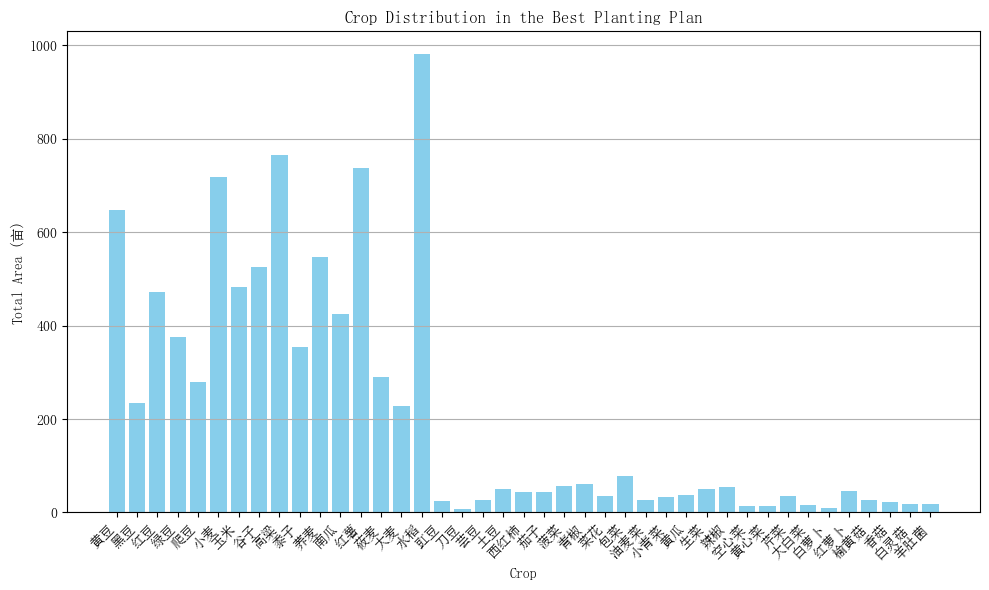

Detailed results have been saved to: result1_1_detailed.xlsx


In [16]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any
import random

# Type aliases
Chromosome = List[List[Dict[str, Any]]]
Population = List[Chromosome]

# Helper functions
def parse_price(price_str: str) -> float:
    if isinstance(price_str, str) and '-' in price_str:
        min_price, max_price = map(float, price_str.split('-'))
        return (min_price + max_price) / 2
    return float(price_str)

def get_seasons_per_year(plot_type: str) -> int:
    if plot_type in ['平旱地', '梯田', '山坡地']:
        return 1
    elif plot_type == '水浇地':
        return 2  # Can be 1 or 2, we'll handle this in the special rules
    elif plot_type in ['普通大棚', '智慧大棚']:
        return 2
    else:
        raise ValueError(f"Unknown plot type: {plot_type}")


# Initialize population
def initialize_population(land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]], num_years: int, population_size: int) -> Population:
    population = []
    for _ in range(population_size):
        chromosome = []
        for _, plot in land_info.iterrows():
            plot_area = plot['地块面积/亩']
            plot_type = plot['地块类型']
            suitable_crops = crop_suitability.get(plot_type, [])
            seasons_per_year = get_seasons_per_year(plot_type)
            
            if not suitable_crops:
                raise ValueError(f"No suitable crops found for plot type: {plot_type}")
            
            plot_plan = []
            for _ in range(num_years):
                year_plan = []
                for _ in range(seasons_per_year):
                    season_plan = {'crop_id': np.random.choice(suitable_crops), 'area': plot_area}
                    year_plan.append(season_plan)
                plot_plan.append(year_plan)
            chromosome.append(plot_plan)
        
        # Apply special rules immediately after initialization
        chromosome = apply_special_rules(chromosome, land_info)
        population.append(chromosome)
    return population


# Calculate fitness
def calculate_fitness(chromosome: Chromosome, land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float]) -> float:
    total_revenue = 0
    penalty = 0
    for plot_index, plot in enumerate(chromosome):
        plot_area = land_info.iloc[plot_index]['地块面积/亩']
        previous_crop = None
        
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if area > plot_area:
                    return float('-inf')  # Invalid solution
                
                if crop_id == 0:  # Empty season
                    continue
                
                crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                if crop_stats.empty:
                    continue
                
                crop_yield = crop_stats['亩产量/斤'].values[0]
                crop_cost = crop_stats['种植成本/(元/亩)'].values[0]
                crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])
                
                demand = market_demand.get(crop_id, 0)
                production = area * crop_yield
                normal_sales = min(production, demand) * crop_price
                excess_production = max(production - demand, 0)
                discounted_sales = excess_production * crop_price * 0.3  # Increased penalty for overproduction
                
                revenue = normal_sales + discounted_sales - (area * crop_cost)
                total_revenue += revenue
                
                # Penalty for continuous planting
                if previous_crop == crop_id:
                    penalty += 0.1 * revenue  # 10% penalty for continuous planting
                previous_crop = crop_id
    
    return total_revenue - penalty

# Selection operation
def selection(population: Population, fitnesses: List[float], tournament_size: int = 5) -> Population:
    selected = []
    for _ in range(len(population)):
        candidates = random.sample(range(len(population)), tournament_size)
        winner = max(candidates, key=lambda i: fitnesses[i])
        selected.append(population[winner])
    return selected

# Crossover operation
def crossover(parent1: Chromosome, parent2: Chromosome, crossover_rate: float) -> tuple[Chromosome, Chromosome]:
    if np.random.rand() < crossover_rate:
        child1, child2 = [], []
        for plot1, plot2 in zip(parent1, parent2):
            if np.random.rand() < 0.5:  # 50% chance of using uniform crossover
                child1_plot, child2_plot = [], []
                for year1, year2 in zip(plot1, plot2):
                    child1_year = [season1 if np.random.rand() < 0.5 else season2 for season1, season2 in zip(year1, year2)]
                    child2_year = [season2 if np.random.rand() < 0.5 else season1 for season1, season2 in zip(year1, year2)]
                    child1_plot.append(child1_year)
                    child2_plot.append(child2_year)
            else:  # 50% chance of using single-point crossover
                crossover_point = np.random.randint(1, len(plot1))
                child1_plot = plot1[:crossover_point] + plot2[crossover_point:]
                child2_plot = plot2[:crossover_point] + plot1[crossover_point:]
            child1.append(child1_plot)
            child2.append(child2_plot)
        return child1, child2
    return parent1, parent2

# Mutation operation
def mutate(chromosome: Chromosome, crop_suitability: Dict[str, List[int]], land_info: pd.DataFrame, mutation_rate: float) -> Chromosome:
    for plot_index, plot in enumerate(chromosome):
        plot_type = land_info.iloc[plot_index]['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = land_info.iloc[plot_index]['地块面积/亩']
        
        for year in plot:
            for season in year:
                if np.random.rand() < mutation_rate:
                    # Mutate crop selection
                    season['crop_id'] = np.random.choice(suitable_crops)
                if np.random.rand() < mutation_rate / 2:  # Lower probability for area mutation
                    # Mutate area (with some constraints)
                    season['area'] = max(0.5 * plot_area, min(plot_area, season['area'] + np.random.normal(0, 0.1 * plot_area)))
    return chromosome

# Enforce land suitability
def enforce_land_suitability(chromosome: Chromosome, land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]]) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = plot_info['地块面积/亩']
        
        if not suitable_crops:
            raise ValueError(f"No suitable crops found for plot type: {plot_type}")
        
        for year in chromosome[plot_index]:
            for season in year:
                if season['crop_id'] not in suitable_crops:
                    season['crop_id'] = np.random.choice(suitable_crops)
                season['area'] = plot_area  # Always use full area
    
    return chromosome


# Apply special rules
def apply_special_rules(chromosome: Chromosome, land_info: pd.DataFrame) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        plot_area = plot_info['地块面积/亩']
        
        if plot_type == '水浇地':
            for year in chromosome[plot_index]:
                if np.random.rand() < 0.5:
                    # Plant rice in the first season
                    year[0] = {'crop_id': 16, 'area': plot_area}
                    # Leave second season empty
                    year[1] = {'crop_id': 0, 'area': 0}
                else:
                    # Plant vegetables in two seasons
                    vegetable_ids = [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
                    year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                    year[1] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
        
        elif plot_type in ['普通大棚', '智慧大棚']:
            vegetable_ids = [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33]
            mushroom_ids = [38, 39, 40, 41]
            for year in chromosome[plot_index]:
                year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                year[1] = {'crop_id': np.random.choice(mushroom_ids), 'area': plot_area}
    
    return chromosome

# Main genetic algorithm loop
import matplotlib.pyplot as plt

# Main genetic algorithm loop with fitness tracking
def genetic_algorithm(land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float], 
                      crop_suitability: Dict[str, List[int]], num_years: int,
                      population_size: int, max_generations: int, crossover_rate: float, mutation_rate: float) -> Chromosome:
    population = initialize_population(land_info, crop_suitability, num_years, population_size)
    
    best_solution = None
    best_fitness = float('-inf')
    fitness_over_time = []
    generations_without_improvement = 0
    
    for generation in range(max_generations):
        fitnesses = [calculate_fitness(chrom, land_info, statistics_2023, market_demand) for chrom in population]
        
        max_fitness = max(fitnesses)
        fitness_over_time.append(max_fitness)
        
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_solution = population[np.argmax(fitnesses)]
            generations_without_improvement = 0
        else:
            generations_without_improvement += 1
        
        if generations_without_improvement > 50:
            print(f"No improvement for 50 generations. Stopping at generation {generation + 1}")
            break
        
        selected = selection(population, fitnesses)
        
        new_population = [best_solution]  # Elitism
        
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(selected, 2)
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            child1 = mutate(child1, crop_suitability, land_info, mutation_rate)
            child2 = mutate(child2, crop_suitability, land_info, mutation_rate)
            new_population.extend([child1, child2])
        
        population = new_population[:population_size]
        
        population = [apply_special_rules(enforce_land_suitability(chrom, land_info, crop_suitability), land_info) for chrom in population]
        
        # Adaptive mutation rate
        if generations_without_improvement > 10:
            mutation_rate = min(0.5, mutation_rate * 1.05)
        else:
            mutation_rate = max(0.01, mutation_rate * 0.95)
        
        print(f"Generation {generation + 1}, Best fitness: {best_fitness}, Mutation rate: {mutation_rate:.4f}")
    
    return best_solution


# Save results to Excel file
def save_result(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str]):
    crop_distribution = {crop: 0 for crop in crop_names}  # To store the total area of each crop
    
    with pd.ExcelWriter(result_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        for year_index, year in enumerate(years):
            for season in range(2):  # Two seasons
                result_df = pd.DataFrame(columns=['地块名'] + crop_names)
                result_df['地块名'] = land_info['地块名称']
                result_df = result_df.set_index('地块名')
                
                for plot_index, plot in enumerate(best_solution):
                    plot_name = land_info.iloc[plot_index]['地块名称']
                    year_plan = plot[year_index]
                    
                    if season < len(year_plan):
                        crop_id = year_plan[season]['crop_id']
                        area = year_plan[season]['area']
                        
                        if crop_id > 0:  # Ignore empty seasons (crop_id = 0)
                            crop_name = crop_names[crop_id - 1]  # Assume crop IDs start from 1
                            if crop_name in result_df.columns:
                                result_df.at[plot_name, crop_name] = area
                            else:
                                result_df[crop_name] = 0
                                result_df.at[plot_name, crop_name] = area
                            
                            # Update crop distribution
                            crop_distribution[crop_name] += area
                
                # Remove columns with all zero values
                result_df = result_df.loc[:, (result_df != 0).any(axis=0)]
                
                # Reset index to make '地块名' a column again
                result_df = result_df.reset_index()
                
                # Save to Excel
                sheet_name = f"{year}_Season{season+1}"
                result_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"Optimal planting plan has been saved to file: {result_path}")
    
    # Plot the crop distribution
    plt.figure(figsize=(10, 6))
    plt.bar(crop_distribution.keys(), crop_distribution.values(), color='skyblue')
    plt.title('Crop Distribution in the Best Planting Plan')
    plt.xlabel('Crop')
    plt.ylabel('Total Area (亩)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
def save_detailed_results(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str], statistics_2023: pd.DataFrame):
    detailed_results = []
    
    for year_index, year in enumerate(years):
        for plot_index, plot in enumerate(best_solution):
            plot_name = land_info.iloc[plot_index]['地块名称']
            plot_area = land_info.iloc[plot_index]['地块面积/亩']
            
            # 遍历当年的每个季节
            for season_index, season in enumerate(plot[year_index]):  # season_index 表示第几季
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id > 0:
                    crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                    crop_name = crop_names[crop_id - 1]
                    crop_yield = crop_stats['亩产量/斤'].values[0]  # 每亩产量（斤/亩）
                    crop_cost = crop_stats['种植成本/(元/亩)'].values[0]  # 每亩成本（元/亩）
                    crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])  # 销售单价（元/斤）

                    # 计算总产量，保持斤为单位
                    total_production = area * crop_yield  # 总产量 = 种植面积 * 每亩产量

                    # 销售收入，直接以斤计算
                    sales_revenue = total_production * crop_price  # 销售收入 = 总产量 * 销售单价（元/斤）

                    # 种植成本
                    planting_cost = area * crop_cost  # 种植成本 = 种植面积 * 每亩成本

                    # 总利润
                    total_profit = sales_revenue - planting_cost  # 总利润 = 销售收入 - 种植成本

                    # 记录详细结果，增加 "季节" 字段
                    detailed_results.append({
                        '年份': year,
                        '季节': f'第{season_index + 1}季',  # season_index 从 0 开始，显示为第几季
                        '作物': crop_name,
                        '地块名': plot_name,
                        '种植面积 (亩)': area,
                        '总产量 (斤)': total_production,  # 现在以斤为单位
                        '销售收入 (元)': sales_revenue,
                        '种植成本 (元)': planting_cost,
                        '总利润 (元)': total_profit
                    })
    
    # 将结果保存为DataFrame
    detailed_results_df = pd.DataFrame(detailed_results)
    
    # 保存到Excel文件
    detailed_result_path = result_path.replace(".xlsx", "_detailed.xlsx")
    detailed_results_df.to_excel(detailed_result_path, index=False)
    
    print(f"Detailed results have been saved to: {detailed_result_path}")


# Main function
def main():
    # Read data
    land_info = pd.read_excel("附件1.xlsx", sheet_name='乡村的现有耕地')
    statistics_2023 = pd.read_excel("附件2.xlsx", sheet_name='2023年统计的相关数据')
    
    # Clean up plot types by stripping whitespace
    land_info['地块类型'] = land_info['地块类型'].str.strip()
    
    # Define parameters
    result_path = "result1_1.xlsx"
    crop_suitability = {
        '平旱地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '梯田': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '山坡地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '水浇地': [16, 20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23],
        '普通大棚': [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 38, 39, 40, 41],
        '智慧大棚': [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
    }
    
    # Print all unique plot types for debugging
    unique_plot_types = land_info['地块类型'].unique()
    print("Unique plot types in land_info:")
    for plot_type in unique_plot_types:
        print(f"'{plot_type}'")
    
    print("\nPlot types in crop_suitability:")
    for plot_type in crop_suitability.keys():
        print(f"'{plot_type}'")
    
    # Check if all plot types in land_info have corresponding entries in crop_suitability
    for plot_type in unique_plot_types:
        if plot_type not in crop_suitability or not crop_suitability[plot_type]:
            raise ValueError(f"Missing or empty crop suitability list for plot type: '{plot_type}'")
    
    crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
                  '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
                  '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
                  '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']
    market_demand = {
        1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
        9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
        17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
        24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
        32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0,39: 10750.0, 40: 10750.0, 41: 10750.0
    }

    
    # Genetic algorithm parameters
    num_years = 7
    population_size = 100
    max_generations = 10
    crossover_rate = 0.8
    mutation_rate = 0.01
    
    # Years to process
    years = ['2024', '2025', '2026', '2027', '2028', '2029', '2030']

    # Run genetic algorithm to generate optimal planting plan
    best_solution = genetic_algorithm(land_info, statistics_2023, market_demand, crop_suitability, num_years, population_size, max_generations, crossover_rate, mutation_rate)

    # Save optimal solution to Excel (fill in each year's table)
    save_result(best_solution, result_path, land_info, crop_names, years)
        # 保存详细结果到Excel
    save_detailed_results(best_solution, result_path, land_info, crop_names, years, statistics_2023)

if __name__ == "__main__":
    main()

可视化

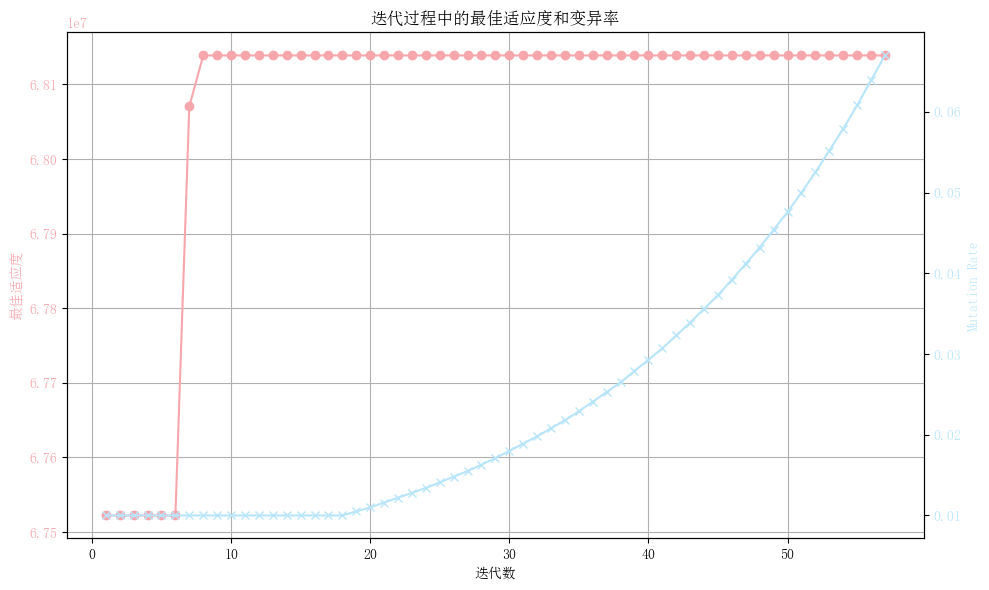

In [90]:
import matplotlib.pyplot as plt

# 数据
generations = list(range(1, 58))  # 代数范围（1到57）
best_fitness = [
    67522248.83333334, 67522248.83333334, 67522248.83333334, 67522248.83333334, 67522248.83333334, 
    67522248.83333334, 68070563.10000001, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 68138883.43333332, 
    68138883.43333332, 68138883.43333332
]
mutation_rates = [
    0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 
    0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0105, 0.0110, 0.0116, 0.0122, 0.0128, 0.0134, 
    0.0141, 0.0148, 0.0155, 0.0163, 0.0171, 0.0180, 0.0189, 0.0198, 0.0208, 0.0218, 0.0229, 0.0241, 
    0.0253, 0.0265, 0.0279, 0.0293, 0.0307, 0.0323, 0.0339, 0.0356, 0.0373, 0.0392, 0.0412, 0.0432, 
    0.0454, 0.0476, 0.0500, 0.0525, 0.0552, 0.0579, 0.0608, 0.0639, 0.0670
]  # 修剪到 57 个元素

# 定义颜色
fitness_color = (247/255, 166/255, 172/255)  # RGB: 247 166 172
mutation_rate_color = (184/255, 229/255, 250/255)  # RGB: 184 229 250

# 创建图表
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制最佳适应度
ax1.set_xlabel('迭代数')
ax1.set_ylabel('最佳适应度', color=fitness_color)
ax1.plot(generations, best_fitness, color=fitness_color, marker='o', label='Best Fitness')
ax1.tick_params(axis='y', labelcolor=fitness_color)
ax1.grid(True)

# 在第二个y轴绘制变异率
ax2 = ax1.twinx()
ax2.set_ylabel('Mutation Rate', color=mutation_rate_color)
ax2.plot(generations, mutation_rates, color=mutation_rate_color, marker='x', label='Mutation Rate')
ax2.tick_params(axis='y', labelcolor=mutation_rate_color)

# 设置标题和布局
plt.title('迭代过程中的最佳适应度和变异率')
fig.tight_layout()

# 显示图表
plt.show()




In [15]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

# Type aliases
Chromosome = List[List[Dict[str, Any]]]
Population = List[Chromosome]

# Helper functions
def parse_price(price_str: str) -> float:
    if isinstance(price_str, str) and '-' in price_str:
        min_price, max_price = map(float, price_str.split('-'))
        return (min_price + max_price) / 2
    return float(price_str)
def calculate_crop_percentages(best_solution: List[List[Dict[str, Any]]], land_info: pd.DataFrame, crop_names: List[str], num_years: int) -> Dict[str, List[float]]:
    crop_percentages = {crop: [0] * num_years for crop in crop_names}
    total_area = land_info['地块面积/亩'].sum()

    for year in range(num_years):
        crop_areas = {crop: 0 for crop in crop_names}
        for plot_index, plot in enumerate(best_solution):
            plot_area = land_info.iloc[plot_index]['地块面积/亩']
            for season in plot[year]:
                crop_id = season['crop_id']
                if crop_id > 0:
                    crop_name = crop_names[crop_id - 1]
                    crop_areas[crop_name] += season['area']
        
        for crop in crop_names:
            crop_percentages[crop][year] = (crop_areas[crop] / total_area) * 100

    return crop_percentages
colors = ['#F7A6AC', '#EEF0A7', '#B2DBB9', '#B8E5FA', '#EEC186']
def plot_crop_percentages(crop_percentages: Dict[str, List[float]], years: List[str], output_file: str):
    plt.figure(figsize=(15, 10))
    crops = list(crop_percentages.keys())
    bottom = np.zeros(len(years))

    for i, crop in enumerate(crops):
        plt.bar(years, crop_percentages[crop], bottom=bottom, label=crop, color=colors[i % len(colors)])
        bottom += crop_percentages[crop]

    plt.title('Crop Distribution Over Years')
    plt.xlabel('Year')
    plt.ylabel('Percentage of Total Area')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()
def plot_top_crops(crop_percentages: Dict[str, List[float]], years: List[str], output_file: str, top_n: int = 5):
    avg_percentages = {crop: np.mean(percentages) for crop, percentages in crop_percentages.items()}
    top_crops = sorted(avg_percentages, key=avg_percentages.get, reverse=True)[:top_n]

    plt.figure(figsize=(15, 10))
    for i, crop in enumerate(top_crops):
        plt.plot(years, crop_percentages[crop], marker='o', label=crop, color=colors[i % len(colors)])

    plt.title(f'Top {top_n} Crops Over Years')
    plt.xlabel('Year')
    plt.ylabel('Percentage of Total Area')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()
def visualize_planting_plan(best_solution: List[List[Dict[str, Any]]], land_info: pd.DataFrame, crop_names: List[str], years: List[str]):
    num_years = len(years)
    crop_percentages = calculate_crop_percentages(best_solution, land_info, crop_names, num_years)

    # Plot overall crop distribution
    plot_crop_percentages(crop_percentages, years, 'crop_distribution.png')

    # Plot top 5 crops over years
    plot_top_crops(crop_percentages, years, 'top_5_crops.png')



def get_seasons_per_year(plot_type: str) -> int:
    if plot_type in ['平旱地', '梯田', '山坡地']:
        return 1
    elif plot_type == '水浇地':
        return 2  # Can be 1 or 2, we'll handle this in the special rules
    elif plot_type in ['普通大棚', '智慧大棚']:
        return 2
    else:
        raise ValueError(f"Unknown plot type: {plot_type}")
def calculate_max_area(crop_id: int, plot_area: float, crop_yield: float, market_demand: float) -> float:
    """Calculate the maximum area that can be planted without exceeding market demand."""
    if crop_yield > 0:
        return min(plot_area, market_demand / crop_yield)
    return 0
# Initialize population
# 修改 initialize_population 函数
def initialize_population(land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]], 
                          statistics_2023: pd.DataFrame, market_demand: Dict[int, float],
                          num_years: int, population_size: int) -> Population:
    population = []
    for _ in range(population_size):
        chromosome = []
        for _, plot in land_info.iterrows():
            plot_area = plot['地块面积/亩']
            plot_type = plot['地块类型']
            suitable_crops = crop_suitability.get(plot_type, [])
            seasons_per_year = get_seasons_per_year(plot_type)
            
            if not suitable_crops:
                raise ValueError(f"No suitable crops found for plot type: {plot_type}")
            
            plot_plan = []
            for _ in range(num_years):
                year_plan = []
                for _ in range(seasons_per_year):
                    if np.random.rand() < 0.1:  # 10% 概率不种植任何作物
                        season_plan = {'crop_id': 0, 'area': 0}
                    else:
                        crop_id = np.random.choice(suitable_crops)
                        crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                        crop_yield = crop_stats['亩产量/斤'].values[0]
                        max_area = calculate_max_area(crop_id, plot_area, crop_yield, market_demand.get(crop_id, 0))
                        area = np.random.uniform(0, max_area)
                        season_plan = {'crop_id': crop_id, 'area': area}
                    year_plan.append(season_plan)
                plot_plan.append(year_plan)
            chromosome.append(plot_plan)
        population.append(chromosome)
    return population



# Calculate fitness
def calculate_fitness(chromosome: Chromosome, land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float]) -> float:
    total_revenue = 0
    for plot_index, plot in enumerate(chromosome):
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id == 0:  # 如果没有种植作物，收益为0
                    continue
                
                crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                if crop_stats.empty:
                    print(f"警告：在统计数据中找不到作物ID {crop_id}。跳过此作物的收益计算。")
                    continue
                
                crop_yield = crop_stats['亩产量/斤'].values[0]
                crop_cost = crop_stats['种植成本/(元/亩)'].values[0]
                crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])
                
                production = area * crop_yield
                revenue = (production * crop_price) - (area * crop_cost)
                total_revenue += revenue
    
    return total_revenue

# Selection operation
def selection(population: Population, fitnesses: List[float], tournament_size: int = 3) -> Population:
    selected = []
    for _ in range(len(population)):
        candidates = np.random.choice(range(len(population)), tournament_size, replace=False)
        winner = max(candidates, key=lambda i: fitnesses[i])
        selected.append(population[winner])
    return selected

# Crossover operation
def crossover(parent1: Chromosome, parent2: Chromosome, crossover_rate: float) -> tuple[Chromosome, Chromosome]:
    if np.random.rand() < crossover_rate:
        child1, child2 = [], []
        for plot1, plot2 in zip(parent1, parent2):
            crossover_point = np.random.randint(1, len(plot1))
            child1.append(plot1[:crossover_point] + plot2[crossover_point:])
            child2.append(plot2[:crossover_point] + plot1[crossover_point:])
        return child1, child2
    return parent1, parent2

# Mutation operation
# 修改 mutate 函数
def mutate(chromosome: Chromosome, crop_suitability: Dict[str, List[int]], land_info: pd.DataFrame, 
           statistics_2023: pd.DataFrame, market_demand: Dict[int, float], mutation_rate: float) -> Chromosome:
    for plot_index, plot in enumerate(chromosome):
        plot_type = land_info.iloc[plot_index]['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = land_info.iloc[plot_index]['地块面积/亩']
        
        for year in plot:
            if np.random.rand() < mutation_rate:
                for season in year:
                    if np.random.rand() < 0.1:  # 10% 概率变异为不种植
                        season['crop_id'] = 0
                        season['area'] = 0
                    else:
                        if np.random.rand() < 0.5:  # 50% 概率改变作物类型
                            season['crop_id'] = np.random.choice(suitable_crops)
                        
                        crop_id = season['crop_id']
                        if crop_id != 0:
                            crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                            crop_yield = crop_stats['亩产量/斤'].values[0]
                            max_area = calculate_max_area(crop_id, plot_area, crop_yield, market_demand.get(crop_id, 0))
                            season['area'] = np.random.uniform(0, max_area)
    return chromosome


# Enforce land suitability
def enforce_land_suitability(chromosome: Chromosome, land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]]) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = plot_info['地块面积/亩']
        
        if not suitable_crops:
            raise ValueError(f"No suitable crops found for plot type: {plot_type}")
        
        for year in chromosome[plot_index]:
            for season in year:
                if season['crop_id'] not in suitable_crops:
                    season['crop_id'] = np.random.choice(suitable_crops)
                season['area'] = plot_area  # Always use full area
    
    return chromosome


# Apply special rules
def apply_special_rules(chromosome: Chromosome, land_info: pd.DataFrame) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        plot_area = plot_info['地块面积/亩']
        
        if plot_type == '水浇地':
            for year in chromosome[plot_index]:
                if np.random.rand() < 0.5:
                    # Plant rice in the first season
                    year[0] = {'crop_id': 16, 'area': plot_area}
                    # Leave second season empty
                    year[1] = {'crop_id': 0, 'area': 0}
                else:
                    # Plant vegetables in two seasons
                    vegetable_ids = [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
                    year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                    year[1] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
        
        elif plot_type in ['普通大棚', '智慧大棚']:
            vegetable_ids = [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33]
            mushroom_ids = [38, 39, 40, 41]
            for year in chromosome[plot_index]:
                year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                year[1] = {'crop_id': np.random.choice(mushroom_ids), 'area': plot_area}
    
    return chromosome

# Main genetic algorithm loop
def genetic_algorithm(land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float], 
                      crop_suitability: Dict[str, List[int]], num_years: int,
                      population_size: int, max_generations: int, crossover_rate: float, mutation_rate: float) -> Chromosome:
    population = initialize_population(land_info, crop_suitability, statistics_2023, market_demand, num_years, population_size)
    
    best_solution = None
    best_fitness = float('-inf')
    
    for generation in range(max_generations):
        # Apply land suitability and special rules
        population = [enforce_land_suitability(chrom, land_info, crop_suitability) for chrom in population]
        population = [apply_special_rules(chrom, land_info) for chrom in population]
        
        # Calculate fitness
        fitnesses = [calculate_fitness(chrom, land_info, statistics_2023, market_demand) for chrom in population]
        
        # Update best solution
        max_fitness = max(fitnesses)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_solution = population[np.argmax(fitnesses)]
        
        # Selection
        selected = selection(population, fitnesses)
        
        # Crossover and mutation
        new_population = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[min(i+1, len(selected)-1)]
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            child1 = mutate(child1, crop_suitability, land_info, statistics_2023, market_demand, mutation_rate)
            child2 = mutate(child2, crop_suitability, land_info, statistics_2023, market_demand, mutation_rate)
            new_population.extend([child1, child2])
        
        population = new_population[:population_size]  # Ensure population size remains constant
        
        print(f"Generation {generation + 1}, Best fitness: {best_fitness}")
    
    return best_solution

# Save results to Excel file
def save_detailed_results(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str], statistics_2023: pd.DataFrame):
    detailed_results = []
    
    for year_index, year in enumerate(years):
        for plot_index, plot in enumerate(best_solution):
            plot_name = land_info.iloc[plot_index]['地块名称']
            plot_area = land_info.iloc[plot_index]['地块面积/亩']
            
            for season_index, season in enumerate(plot[year_index]):
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id > 0:
                    crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                    crop_name = crop_names[crop_id - 1]
                    crop_yield = crop_stats['亩产量/斤'].values[0]
                    crop_cost = crop_stats['种植成本/(元/亩)'].values[0]
                    crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])

                    # Calculate metrics
                    total_production = area * crop_yield / 1000  # 计算产量，转为吨
                    sales_revenue = area * crop_yield * crop_price  # 销售收入，用亩产量 * 销售单价计算，避免单位问题
                    planting_cost = area * crop_cost  # 种植成本
                    total_profit = sales_revenue - planting_cost  # 总利润 = 销售收入 - 种植成本
                    
                    # Add to the detailed results
                    detailed_results.append({
                        '年份': year,
                        '作物': crop_name,
                        '地块名': plot_name,
                        '种植面积 (亩)': area,
                        '总产量 (吨)': total_production,
                        '销售收入 (元)': sales_revenue,
                        '种植成本 (元)': planting_cost,
                        '总利润 (元)': total_profit
                    })
    
    # Create DataFrame from the results
    detailed_results_df = pd.DataFrame(detailed_results)
    
    # Save to Excel
    detailed_result_path = result_path.replace(".xlsx", "_detailed.xlsx")
    detailed_results_df.to_excel(detailed_result_path, index=False)
    
    print(f"Detailed results have been saved to: {detailed_result_path}")

    
    # Create DataFrame from the results
    detailed_results_df = pd.DataFrame(detailed_results)
    
    # Save to Excel
    detailed_result_path = result_path.replace(".xlsx", "_detailed.xlsx")
    detailed_results_df.to_excel(detailed_result_path, index=False)
    
    print(f"Detailed results have been saved to: {detailed_result_path}")
def save_detailed_results(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str], statistics_2023: pd.DataFrame):
    detailed_results = []
    
    for year_index, year in enumerate(years):
        for plot_index, plot in enumerate(best_solution):
            plot_name = land_info.iloc[plot_index]['地块名称']
            plot_area = land_info.iloc[plot_index]['地块面积/亩']
            
            # 遍历当年的每个季节
            for season_index, season in enumerate(plot[year_index]):  # season_index 表示第几季
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id > 0:
                    crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                    crop_name = crop_names[crop_id - 1]
                    crop_yield = crop_stats['亩产量/斤'].values[0]  # 每亩产量（斤/亩）
                    crop_cost = crop_stats['种植成本/(元/亩)'].values[0]  # 每亩成本（元/亩）
                    crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])  # 销售单价（元/斤）

                    # 计算总产量，保持斤为单位
                    total_production = area * crop_yield  # 总产量 = 种植面积 * 每亩产量

                    # 销售收入，直接以斤计算
                    sales_revenue = total_production * crop_price  # 销售收入 = 总产量 * 销售单价（元/斤）

                    # 种植成本
                    planting_cost = area * crop_cost  # 种植成本 = 种植面积 * 每亩成本

                    # 总利润
                    total_profit = sales_revenue - planting_cost  # 总利润 = 销售收入 - 种植成本

                    # 记录详细结果，增加 "季节" 字段
                    detailed_results.append({
                        '年份': year,
                        '季节': f'第{season_index + 1}季',  # season_index 从 0 开始，显示为第几季
                        '作物': crop_name,
                        '地块名': plot_name,
                        '种植面积 (亩)': area,
                        '总产量 (斤)': total_production,  # 现在以斤为单位
                        '销售收入 (元)': sales_revenue,
                        '种植成本 (元)': planting_cost,
                        '总利润 (元)': total_profit
                    })
    
    # 将结果保存为DataFrame
    detailed_results_df = pd.DataFrame(detailed_results)
    
    # 保存到Excel文件
    detailed_result_path = result_path.replace(".xlsx", "_detailed.xlsx")
    detailed_results_df.to_excel(detailed_result_path, index=False)
    
    print(f"Detailed results have been saved to: {detailed_result_path}")



# Main function
def main():
    # Read data
    land_info = pd.read_excel("附件1.xlsx", sheet_name='乡村的现有耕地')
    statistics_2023 = pd.read_excel("附件2.xlsx", sheet_name='2023年统计的相关数据')
    
    # Clean up plot types by stripping whitespace
    land_info['地块类型'] = land_info['地块类型'].str.strip()
    
    # Define parameters
    result_path1 = "result1_2.xlsx"
    result_path2= "result1_2_detail.xlsx"
    crop_suitability = {
        '平旱地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '梯田': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '山坡地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '水浇地': [16, 20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23],
        '普通大棚': [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 38, 39, 40, 41],
        '智慧大棚': [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
    }
    
    crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
                  '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
                  '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
                  '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']
    
    market_demand = {
        1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
        9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
        17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
        24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
        32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0,39: 10750.0, 40: 10750.0, 41: 10750.0
    }
    
    # Genetic algorithm parameters
    num_years = 7
    population_size = 100
    max_generations = 10
    crossover_rate = 0.8
    mutation_rate = 0.01
    
    # Years to process
    years = ['2024', '2025', '2026', '2027', '2028', '2029', '2030']

   # 运行遗传算法生成最优种植方案
    best_solution = genetic_algorithm(land_info, statistics_2023, market_demand, crop_suitability, num_years, population_size, max_generations, crossover_rate, mutation_rate)

    # 保存最优解到Excel（填写每年的表格）
    save_result(best_solution, result_path1, land_info, crop_names, years)

    # 保存详细结果到Excel
    save_detailed_results(best_solution, result_path2, land_info, crop_names, years, statistics_2023)

    # 生成可视化
    visualize_planting_plan(best_solution, land_info, crop_names, years)

if __name__ == "__main__":
    main()

Generation 1, Best fitness: 61086398.75
Generation 2, Best fitness: 61086398.75
Generation 3, Best fitness: 61086398.75
Generation 4, Best fitness: 64041586.25
Generation 5, Best fitness: 64041586.25
Generation 6, Best fitness: 64041586.25
Generation 7, Best fitness: 64041586.25
Generation 8, Best fitness: 64041586.25
Generation 9, Best fitness: 64041586.25
Generation 10, Best fitness: 64041586.25
Optimal planting plan has been saved to file: result1_2.xlsx
Detailed results have been saved to: result1_2_detail_detailed.xlsx


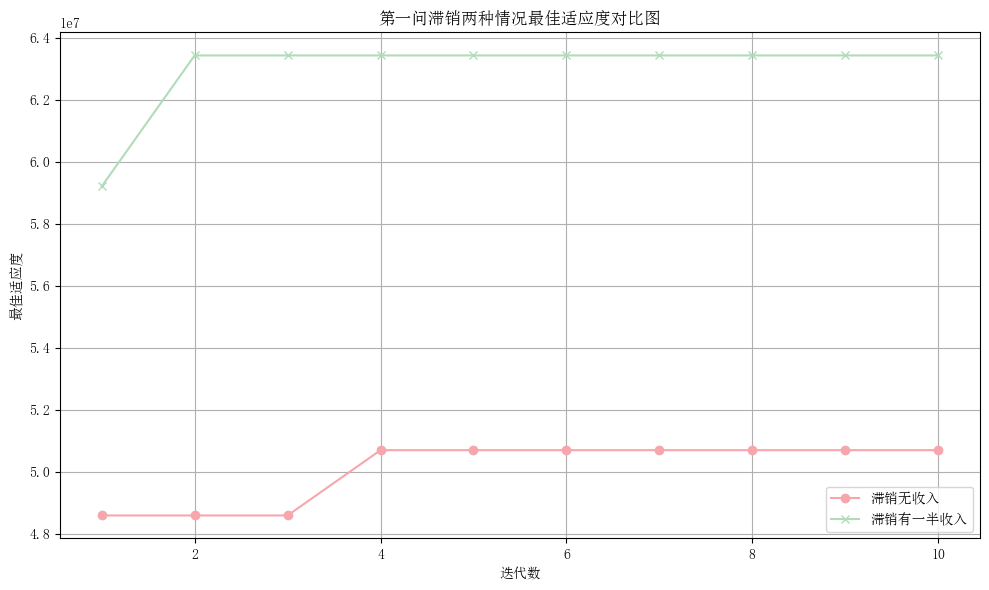

In [8]:
import matplotlib.pyplot as plt

# 数据集1
generations_1 = list(range(1, 11))
best_fitness_1 = [
    48596391.05, 48596391.05, 48596391.05, 50702171.95, 50702171.95, 
    50702171.95, 50702171.95, 50702171.95, 50702171.95, 50702171.95
]
mutation_rates_1 = [0.0100] * 10

# 数据集2
generations_2 = list(range(1, 11))
best_fitness_2 = [
    59208481.25, 63430810.0, 63430810.0, 63430810.0, 63430810.0, 
    63430810.0, 63430810.0, 63430810.0, 63430810.0, 63430810.0
]

# 配色
fitness_color_1 = (247/255, 166/255, 172/255)  # RGB: 247 166 172
fitness_color_2 = (178/255, 219/255, 185/255)  # RGB: 178 219 185

# 创建图表
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制数据集1的最佳适应度
ax.plot(generations_1, best_fitness_1, color=fitness_color_1, marker='o', label='滞销无收入')
# 绘制数据集2的最佳适应度
ax.plot(generations_2, best_fitness_2, color=fitness_color_2, marker='x', label='滞销有一半收入')

# 设置标签
ax.set_xlabel('迭代数')
ax.set_ylabel('最佳适应度')
ax.set_title('第一问滞销两种情况最佳适应度对比图')

# 添加图例
ax.legend()

# 显示网格
ax.grid(True)

# 布局优化
fig.tight_layout()

# 显示图表
plt.show()


第二问

In [18]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

# Type aliases
Chromosome = List[List[Dict[str, Any]]]
Population = List[Chromosome]

# Helper functions
def parse_price(price_str: str) -> float:
    if isinstance(price_str, str) and '-' in price_str:
        min_price, max_price = map(float, price_str.split('-'))
        return (min_price + max_price) / 2
    return float(price_str)

def get_seasons_per_year(plot_type: str) -> int:
    if plot_type in ['平旱地', '梯田', '山坡地']:
        return 1
    elif plot_type == '水浇地':
        return 2  # Can be 1 or 2, we'll handle this in the special rules
    elif plot_type in ['普通大棚', '智慧大棚']:
        return 2
    else:
        raise ValueError(f"Unknown plot type: {plot_type}")
def calculate_max_area(crop_id: int, plot_area: float, crop_yield: float, market_demand: float) -> float:
    """Calculate the maximum area that can be planted without exceeding market demand."""
    if crop_yield > 0:
        return min(plot_area, market_demand / crop_yield)
    return 0
# Initialize population
# 修改 initialize_population 函数
def initialize_population(land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]], 
                          statistics_2023: pd.DataFrame, market_demand: Dict[int, float],
                          num_years: int, population_size: int) -> Population:
    population = []
    for _ in range(population_size):
        chromosome = []
        for _, plot in land_info.iterrows():
            plot_area = plot['地块面积/亩']
            plot_type = plot['地块类型']
            suitable_crops = crop_suitability.get(plot_type, [])
            seasons_per_year = get_seasons_per_year(plot_type)
            
            if not suitable_crops:
                raise ValueError(f"No suitable crops found for plot type: {plot_type}")
            
            plot_plan = []
            for _ in range(num_years):
                year_plan = []
                for _ in range(seasons_per_year):
                    if np.random.rand() < 0.1:  # 10% 概率不种植任何作物
                        season_plan = {'crop_id': 0, 'area': 0}
                    else:
                        crop_id = np.random.choice(suitable_crops)
                        crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                        crop_yield = crop_stats['亩产量/斤'].values[0]
                        max_area = calculate_max_area(crop_id, plot_area, crop_yield, market_demand.get(crop_id, 0))
                        area = np.random.uniform(0, max_area)
                        season_plan = {'crop_id': crop_id, 'area': area}
                    year_plan.append(season_plan)
                plot_plan.append(year_plan)
            chromosome.append(plot_plan)
        population.append(chromosome)
    return population



# Calculate fitness
def calculate_fitness(chromosome: Chromosome, land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float]) -> float:
    total_revenue = 0
    for plot_index, plot in enumerate(chromosome):
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id == 0:  # 如果没有种植作物，收益为0
                    continue
                
                crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                if crop_stats.empty:
                    print(f"警告：在统计数据中找不到作物ID {crop_id}。跳过此作物的收益计算。")
                    continue
                
                crop_yield = crop_stats['亩产量/斤'].values[0]
                crop_cost = crop_stats['种植成本/(元/亩)'].values[0]
                crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])
                
                production = area * crop_yield
                revenue = (production * crop_price) - (area * crop_cost)
                total_revenue += revenue
    
    return total_revenue

# Selection operation
def selection(population: Population, fitnesses: List[float], tournament_size: int = 3) -> Population:
    selected = []
    for _ in range(len(population)):
        candidates = np.random.choice(range(len(population)), tournament_size, replace=False)
        winner = max(candidates, key=lambda i: fitnesses[i])
        selected.append(population[winner])
    return selected

# Crossover operation
def crossover(parent1: Chromosome, parent2: Chromosome, crossover_rate: float) -> tuple[Chromosome, Chromosome]:
    if np.random.rand() < crossover_rate:
        child1, child2 = [], []
        for plot1, plot2 in zip(parent1, parent2):
            crossover_point = np.random.randint(1, len(plot1))
            child1.append(plot1[:crossover_point] + plot2[crossover_point:])
            child2.append(plot2[:crossover_point] + plot1[crossover_point:])
        return child1, child2
    return parent1, parent2

# Mutation operation
# 修改 mutate 函数
def mutate(chromosome: Chromosome, crop_suitability: Dict[str, List[int]], land_info: pd.DataFrame, 
           statistics_2023: pd.DataFrame, market_demand: Dict[int, float], mutation_rate: float) -> Chromosome:
    for plot_index, plot in enumerate(chromosome):
        plot_type = land_info.iloc[plot_index]['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = land_info.iloc[plot_index]['地块面积/亩']
        
        for year in plot:
            if np.random.rand() < mutation_rate:
                for season in year:
                    if np.random.rand() < 0.1:  # 10% 概率变异为不种植
                        season['crop_id'] = 0
                        season['area'] = 0
                    else:
                        if np.random.rand() < 0.5:  # 50% 概率改变作物类型
                            season['crop_id'] = np.random.choice(suitable_crops)
                        
                        crop_id = season['crop_id']
                        if crop_id != 0:
                            crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                            crop_yield = crop_stats['亩产量/斤'].values[0]
                            max_area = calculate_max_area(crop_id, plot_area, crop_yield, market_demand.get(crop_id, 0))
                            season['area'] = np.random.uniform(0, max_area)
    return chromosome


# Enforce land suitability
def enforce_land_suitability(chromosome: Chromosome, land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]]) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = plot_info['地块面积/亩']
        
        if not suitable_crops:
            raise ValueError(f"No suitable crops found for plot type: {plot_type}")
        
        for year in chromosome[plot_index]:
            for season in year:
                if season['crop_id'] not in suitable_crops:
                    season['crop_id'] = np.random.choice(suitable_crops)
                season['area'] = plot_area  # Always use full area
    
    return chromosome


# Apply special rules
def apply_special_rules(chromosome: Chromosome, land_info: pd.DataFrame) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        plot_area = plot_info['地块面积/亩']
        
        if plot_type == '水浇地':
            for year in chromosome[plot_index]:
                if np.random.rand() < 0.5:
                    # Plant rice in the first season
                    year[0] = {'crop_id': 16, 'area': plot_area}
                    # Leave second season empty
                    year[1] = {'crop_id': 0, 'area': 0}
                else:
                    # Plant vegetables in two seasons
                    vegetable_ids = [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
                    year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                    year[1] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
        
        elif plot_type in ['普通大棚', '智慧大棚']:
            vegetable_ids = [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33]
            mushroom_ids = [38, 39, 40, 41]
            for year in chromosome[plot_index]:
                year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                year[1] = {'crop_id': np.random.choice(mushroom_ids), 'area': plot_area}
    
    return chromosome

# Main genetic algorithm loop
def genetic_algorithm(land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float], 
                      crop_suitability: Dict[str, List[int]], num_years: int,
                      population_size: int, max_generations: int, crossover_rate: float, mutation_rate: float) -> Chromosome:
    population = initialize_population(land_info, crop_suitability, statistics_2023, market_demand, num_years, population_size)
    
    best_solution = None
    best_fitness = float('-inf')
    
    for generation in range(max_generations):
        # Apply land suitability and special rules
        population = [enforce_land_suitability(chrom, land_info, crop_suitability) for chrom in population]
        population = [apply_special_rules(chrom, land_info) for chrom in population]
        
        # Calculate fitness
        fitnesses = [calculate_fitness(chrom, land_info, statistics_2023, market_demand) for chrom in population]
        
        # Update best solution
        max_fitness = max(fitnesses)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_solution = population[np.argmax(fitnesses)]
        
        # Selection
        selected = selection(population, fitnesses)
        
        # Crossover and mutation
        new_population = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[min(i+1, len(selected)-1)]
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            child1 = mutate(child1, crop_suitability, land_info, statistics_2023, market_demand, mutation_rate)
            child2 = mutate(child2, crop_suitability, land_info, statistics_2023, market_demand, mutation_rate)
            new_population.extend([child1, child2])
        
        population = new_population[:population_size]  # Ensure population size remains constant
        
        print(f"Generation {generation + 1}, Best fitness: {best_fitness}")
    
    return best_solution

# Save results to Excel file
def save_result(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str]):
    with pd.ExcelWriter(result_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        for year_index, year in enumerate(years):
            for season in range(2):  # Two seasons
                result_df = pd.DataFrame(columns=['地块名'] + crop_names)
                result_df['地块名'] = land_info['地块名称']
                result_df = result_df.set_index('地块名')
                
                for plot_index, plot in enumerate(best_solution):
                    plot_name = land_info.iloc[plot_index]['地块名称']
                    year_plan = plot[year_index]
                    
                    if season < len(year_plan):
                        crop_id = year_plan[season]['crop_id']
                        area = year_plan[season]['area']
                        
                        if crop_id > 0:  # Ignore empty seasons (crop_id = 0)
                            crop_name = crop_names[crop_id - 1]  # Assume crop IDs start from 1
                            if crop_name in result_df.columns:
                                result_df.at[plot_name, crop_name] = area
                            else:
                                result_df[crop_name] = 0
                                result_df.at[plot_name, crop_name] = area
                
                # Remove columns with all zero values
                result_df = result_df.loc[:, (result_df != 0).any(axis=0)]
                
                # Reset index to make '地块名' a column again
                result_df = result_df.reset_index()
                
                # Save to Excel
                sheet_name = f"{year}_Season{season+1}"
                result_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"Optimal planting plan has been saved to file: {result_path}")
def save_detailed_results(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str], statistics_2023: pd.DataFrame):
    detailed_results = []
    
    for year_index, year in enumerate(years):
        for plot_index, plot in enumerate(best_solution):
            plot_name = land_info.iloc[plot_index]['地块名称']
            plot_area = land_info.iloc[plot_index]['地块面积/亩']
            
            # 遍历当年的每个季节
            for season_index, season in enumerate(plot[year_index]):  # season_index 表示第几季
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id > 0:
                    crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                    crop_name = crop_names[crop_id - 1]
                    crop_yield = crop_stats['亩产量/斤'].values[0]  # 每亩产量（斤/亩）
                    crop_cost = crop_stats['种植成本/(元/亩)'].values[0]  # 每亩成本（元/亩）
                    crop_price = parse_price(crop_stats['销售单价/(元/斤)'].values[0])  # 销售单价（元/斤）

                    # 计算总产量，保持斤为单位
                    total_production = area * crop_yield  # 总产量 = 种植面积 * 每亩产量

                    # 销售收入，直接以斤计算
                    sales_revenue = total_production * crop_price  # 销售收入 = 总产量 * 销售单价（元/斤）

                    # 种植成本
                    planting_cost = area * crop_cost  # 种植成本 = 种植面积 * 每亩成本

                    # 总利润
                    total_profit = sales_revenue - planting_cost  # 总利润 = 销售收入 - 种植成本

                    # 记录详细结果，增加 "季节" 字段
                    detailed_results.append({
                        '年份': year,
                        '季节': f'第{season_index + 1}季',  # season_index 从 0 开始，显示为第几季
                        '作物': crop_name,
                        '地块名': plot_name,
                        '种植面积 (亩)': area,
                        '总产量 (斤)': total_production,  # 现在以斤为单位
                        '销售收入 (元)': sales_revenue,
                        '种植成本 (元)': planting_cost,
                        '总利润 (元)': total_profit
                    })
    
    # 将结果保存为DataFrame
    detailed_results_df = pd.DataFrame(detailed_results)
    
    # 保存到Excel文件
    detailed_result_path = result_path.replace(".xlsx", "_detailed.xlsx")
    detailed_results_df.to_excel(detailed_result_path, index=False)
    
    print(f"Detailed results have been saved to: {detailed_result_path}")

# Main function
def main():
    # Read data
    land_info = pd.read_excel("附件1.xlsx", sheet_name='乡村的现有耕地')
    statistics_2023 = pd.read_excel("附件2.xlsx", sheet_name='2023年统计的相关数据')
    
    # Clean up plot types by stripping whitespace
    land_info['地块类型'] = land_info['地块类型'].str.strip()
    
    # Define parameters
    result_path = "result1_2.xlsx"
    crop_suitability = {
        '平旱地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '梯田': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '山坡地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '水浇地': [16, 20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23],
        '普通大棚': [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 38, 39, 40, 41],
        '智慧大棚': [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
    }
    
    # Print all unique plot types for debugging
    unique_plot_types = land_info['地块类型'].unique()
    print("Unique plot types in land_info:")
    for plot_type in unique_plot_types:
        print(f"'{plot_type}'")
    
    print("\nPlot types in crop_suitability:")
    for plot_type in crop_suitability.keys():
        print(f"'{plot_type}'")
    
    # Check if all plot types in land_info have corresponding entries in crop_suitability
    for plot_type in unique_plot_types:
        if plot_type not in crop_suitability or not crop_suitability[plot_type]:
            raise ValueError(f"Missing or empty crop suitability list for plot type: '{plot_type}'")
    
    crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
                  '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
                  '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
                  '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']
    market_demand = {
        1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
        9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
        17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
        24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
        32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0,39: 10750.0, 40: 10750.0, 41: 10750.0
    }
    
    # Genetic algorithm parameters
    num_years = 7
    population_size = 70
    max_generations = 10
    crossover_rate = 0.8
    mutation_rate = 0.01
    
    # Years to process
    years = ['2024', '2025', '2026', '2027', '2028', '2029', '2030']

    # Run genetic algorithm to generate optimal planting plan
    best_solution = genetic_algorithm(land_info, statistics_2023, market_demand, crop_suitability, num_years, population_size, max_generations, crossover_rate, mutation_rate)

    # Save optimal solution to Excel (fill in each year's table)
    save_result(best_solution, result_path, land_info, crop_names, years)
            # 保存详细结果到Excel
    save_detailed_results(best_solution, result_path, land_info, crop_names, years, statistics_2023)

if __name__ == "__main__":
    main()

Unique plot types in land_info:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'

Plot types in crop_suitability:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'
Generation 1, Best fitness: 59027196.25
Generation 2, Best fitness: 59027196.25
Generation 3, Best fitness: 59027196.25
Generation 4, Best fitness: 59027196.25
Generation 5, Best fitness: 59257983.75
Generation 6, Best fitness: 59739718.75
Generation 7, Best fitness: 59739718.75
Generation 8, Best fitness: 59739718.75
Generation 9, Best fitness: 59739718.75
Generation 10, Best fitness: 59739718.75
Optimal planting plan has been saved to file: result1_2.xlsx
Detailed results have been saved to: result1_2_detailed.xlsx


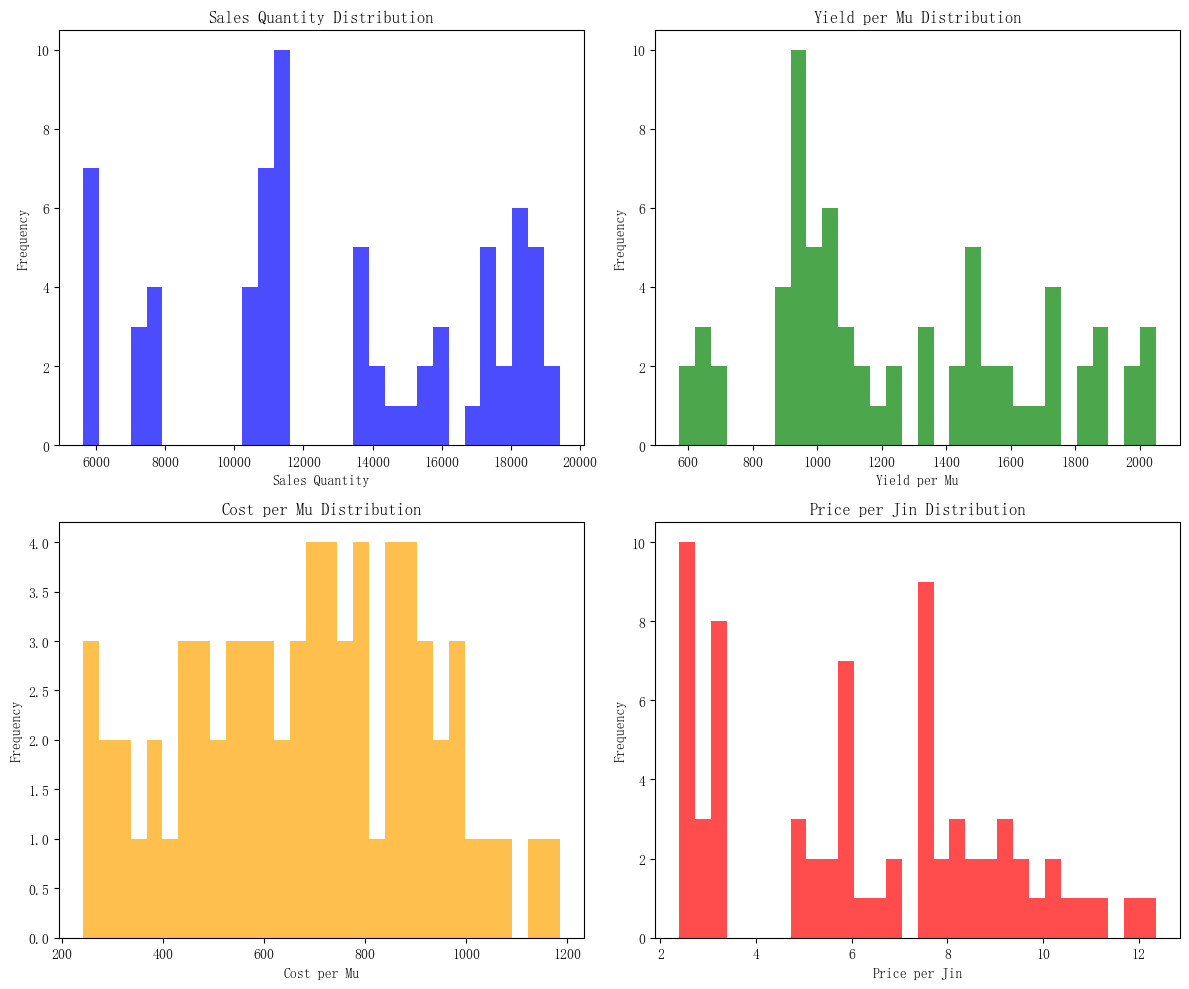

In [21]:
# 模拟数据的数量（例如 7 年的预测数据）
num_years = 7
num_crops = 10  

# 初始的模拟基准数据
base_sales_quantity = np.random.randint(5000, 20000, num_crops)  # 每种作物的初始销售量
base_yield_per_mu = np.random.uniform(500, 2000, num_crops)  # 每种作物的亩产量
base_cost_per_mu = np.random.uniform(200, 1000, num_crops)  # 每种作物的种植成本
base_price_per_jin = np.random.uniform(2, 10, num_crops)  # 每种作物的销售价格

# 初始化用于存储模拟结果的列表
simulated_data = {
    "year": [],
    "crop_id": [],
    "sales_quantity": [],
    "yield_per_mu": [],
    "cost_per_mu": [],
    "price_per_jin": []
}

# 按照代码逻辑生成数据
for year in range(1, num_years + 1):
    for crop_id in range(num_crops):
        # 小麦和玉米的销售量增长率设为 5% 到 10%（假设作物编号 0 和 1 是小麦和玉米）
        if crop_id in [0, 1]:
            growth_rate = np.random.uniform(0.05, 0.10)
            sales_quantity = base_sales_quantity[crop_id] * (1 + growth_rate)
        else:
            # 其他作物的销售量在 ±5% 之间波动
            sales_quantity = base_sales_quantity[crop_id] * np.random.uniform(0.95, 1.05)
        
        # 亩产量的波动为 ±10%
        yield_per_mu = base_yield_per_mu[crop_id] * np.random.uniform(0.90, 1.10)
        
        # 种植成本每年增加 5%
        cost_per_mu = base_cost_per_mu[crop_id] * (1.05 ** year)
        
        # 销售价格根据作物类型变化（假设作物编号 2-4 是蔬菜，5-7 是食用菌，其他为粮食类）
        if crop_id in [2, 3, 4]:  # 蔬菜类
            price_per_jin = base_price_per_jin[crop_id] * 1.05 ** year
        elif crop_id in [5, 6, 7]:  # 食用菌类
            price_per_jin = base_price_per_jin[crop_id] * np.random.uniform(0.95, 0.99) ** year
        else:  # 粮食类作物价格保持不变
            price_per_jin = base_price_per_jin[crop_id]
        
        # 存储模拟结果
        simulated_data["year"].append(year)
        simulated_data["crop_id"].append(crop_id)
        simulated_data["sales_quantity"].append(sales_quantity)
        simulated_data["yield_per_mu"].append(yield_per_mu)
        simulated_data["cost_per_mu"].append(cost_per_mu)
        simulated_data["price_per_jin"].append(price_per_jin)

# 转换为 DataFrame 以便后续可视化
simulated_df = pd.DataFrame(simulated_data)

# 绘制多个变量的图表，如销售量、亩产量、种植成本和价格的分布
plt.figure(figsize=(12, 10))

# 销售量的分布
plt.subplot(2, 2, 1)
plt.hist(simulated_df["sales_quantity"], bins=30, alpha=0.7, color='blue')
plt.title("Sales Quantity Distribution")
plt.xlabel("Sales Quantity")
plt.ylabel("Frequency")

# 亩产量的分布
plt.subplot(2, 2, 2)
plt.hist(simulated_df["yield_per_mu"], bins=30, alpha=0.7, color='green')
plt.title("Yield per Mu Distribution")
plt.xlabel("Yield per Mu")
plt.ylabel("Frequency")

# 种植成本的分布
plt.subplot(2, 2, 3)
plt.hist(simulated_df["cost_per_mu"], bins=30, alpha=0.7, color='orange')
plt.title("Cost per Mu Distribution")
plt.xlabel("Cost per Mu")
plt.ylabel("Frequency")

# 销售价格的分布
plt.subplot(2, 2, 4)
plt.hist(simulated_df["price_per_jin"], bins=30, alpha=0.7, color='red')
plt.title("Price per Jin Distribution")
plt.xlabel("Price per Jin")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()




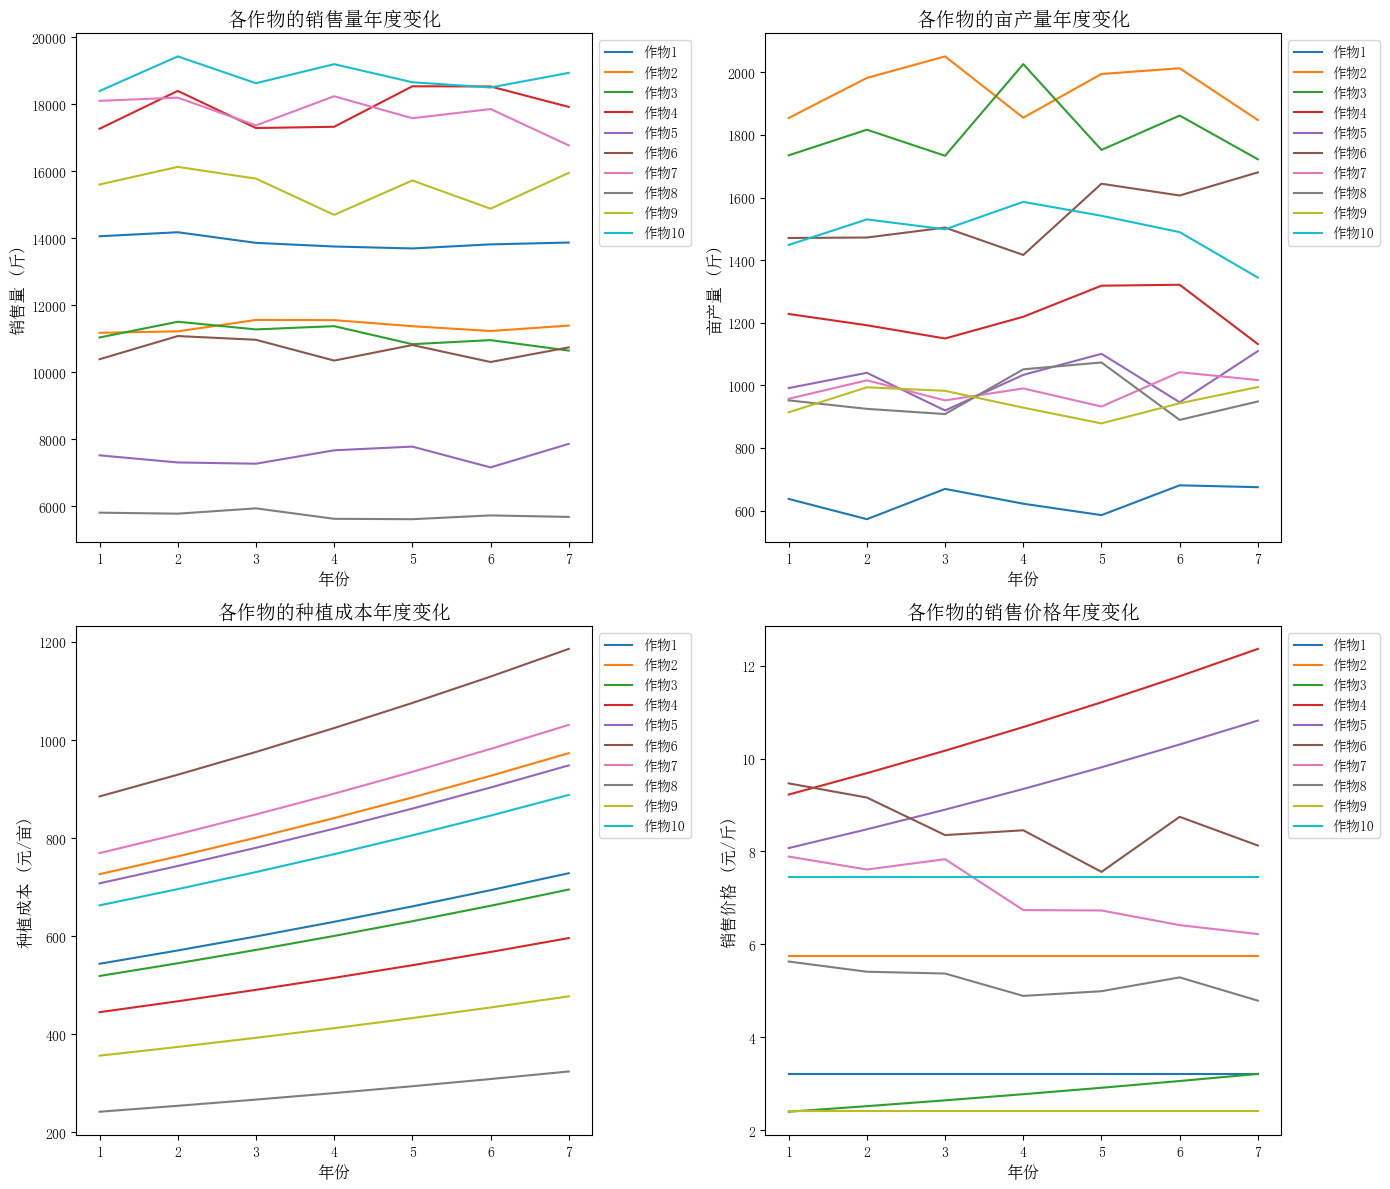

In [23]:
# 绘制更多类型的图表，展示销售量、亩产量、种植成本、销售价格的年度趋势，调整图例位置避免遮挡
plt.figure(figsize=(14, 12))

# 销售量的年度变化趋势
plt.subplot(2, 2, 1)
for crop_id in range(num_crops):
    crop_data = simulated_df[simulated_df['crop_id'] == crop_id]
    plt.plot(crop_data['year'], crop_data['sales_quantity'], label=f'作物{crop_id + 1}')
plt.title("各作物的销售量年度变化", fontsize=14)
plt.xlabel("年份", fontsize=12)
plt.ylabel("销售量 (斤)", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 亩产量的年度变化趋势
plt.subplot(2, 2, 2)
for crop_id in range(num_crops):
    crop_data = simulated_df[simulated_df['crop_id'] == crop_id]
    plt.plot(crop_data['year'], crop_data['yield_per_mu'], label=f'作物{crop_id + 1}')
plt.title("各作物的亩产量年度变化", fontsize=14)
plt.xlabel("年份", fontsize=12)
plt.ylabel("亩产量 (斤)", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 种植成本的年度变化趋势
plt.subplot(2, 2, 3)
for crop_id in range(num_crops):
    crop_data = simulated_df[simulated_df['crop_id'] == crop_id]
    plt.plot(crop_data['year'], crop_data['cost_per_mu'], label=f'作物{crop_id + 1}')
plt.title("各作物的种植成本年度变化", fontsize=14)
plt.xlabel("年份", fontsize=12)
plt.ylabel("种植成本 (元/亩)", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 销售价格的年度变化趋势
plt.subplot(2, 2, 4)
for crop_id in range(num_crops):
    crop_data = simulated_df[simulated_df['crop_id'] == crop_id]
    plt.plot(crop_data['year'], crop_data['price_per_jin'], label=f'作物{crop_id + 1}')
plt.title("各作物的销售价格年度变化", fontsize=14)
plt.xlabel("年份", fontsize=12)
plt.ylabel("销售价格 (元/斤)", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()



In [37]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

# Type aliases
Chromosome = List[List[Dict[str, Any]]]
Population = List[Chromosome]

# Helper functions
def parse_price(price_str: str) -> float:
    if isinstance(price_str, str) and '-' in price_str:
        min_price, max_price = map(float, price_str.split('-'))
        return (min_price + max_price) / 2
    return float(price_str)
import numpy as np

# 销售量增长率和亩产量的蒙特卡洛模拟
def monte_carlo_simulation(statistics_2023: pd.DataFrame, num_years: int) -> List[Dict[str, Any]]:
    yearly_forecasts = []
    
    for year in range(num_years):
        forecast = {}
        for index, row in statistics_2023.iterrows():
            crop_id = row['作物编号']
            crop_type = row['作物类型']  # 根据作物类型区分粮食、蔬菜、食用菌等
            sales_quantity_2023 = row['预期销售量/斤']
            yield_per_mu = row['亩产量/斤']
            cost_per_mu = row['种植成本/(元/亩)']
            price_per_jin = parse_price(row['销售单价/(元/斤)'])

            # 销售量：小麦和玉米年增长率5%-10%，其他作物±5%波动
            if crop_type in ['小麦', '玉米']:
                growth_rate = np.random.uniform(0.05, 0.10)
                sales_quantity = sales_quantity_2023 * (1 + growth_rate)
            else:
                sales_quantity = sales_quantity_2023 * np.random.uniform(0.95, 1.05)
            
            # 亩产量：每年±10%的波动
            yield_per_mu = yield_per_mu * np.random.uniform(0.90, 1.10)
            
            # 种植成本：每年增加5%
            cost_per_mu = cost_per_mu * 1.05
            
            # 销售价格：根据作物类型变化
            if crop_type == '蔬菜':
                price_per_jin *= 1.05  # 蔬菜类价格平均年增长5%
            elif crop_type == '食用菌':
                price_per_jin *= np.random.uniform(0.95, 0.99)  # 食用菌每年下降1%~5%
            # 粮食类作物价格保持不变
            
            forecast[crop_id] = {
                'sales_quantity': sales_quantity,
                'yield_per_mu': yield_per_mu,
                'cost_per_mu': cost_per_mu,
                'price_per_jin': price_per_jin
            }
        
        yearly_forecasts.append(forecast)
    
    return yearly_forecasts


def get_seasons_per_year(plot_type: str) -> int:
    if plot_type in ['平旱地', '梯田', '山坡地']:
        return 1
    elif plot_type == '水浇地':
        return 2  # Can be 1 or 2, we'll handle this in the special rules
    elif plot_type in ['普通大棚', '智慧大棚']:
        return 2
    else:
        raise ValueError(f"Unknown plot type: {plot_type}")
def calculate_max_area(crop_id: int, plot_area: float, crop_yield: float, market_demand: float) -> float:
    """Calculate the maximum area that can be planted without exceeding market demand."""
    if crop_yield > 0:
        return min(plot_area, market_demand / crop_yield)
    return 0
# Initialize population
# 修改 initialize_population 函数
def initialize_population(land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]], 
                          statistics_2023: pd.DataFrame, market_demand: Dict[int, float],
                          num_years: int, population_size: int) -> Population:
    population = []
    for _ in range(population_size):
        chromosome = []
        for _, plot in land_info.iterrows():
            plot_area = plot['地块面积/亩']
            plot_type = plot['地块类型']
            suitable_crops = crop_suitability.get(plot_type, [])
            seasons_per_year = get_seasons_per_year(plot_type)
            
            if not suitable_crops:
                raise ValueError(f"No suitable crops found for plot type: {plot_type}")
            
            plot_plan = []
            for _ in range(num_years):
                year_plan = []
                for _ in range(seasons_per_year):
                    if np.random.rand() < 0.1:  # 10% 概率不种植任何作物
                        season_plan = {'crop_id': 0, 'area': 0}
                    else:
                        crop_id = np.random.choice(suitable_crops)
                        crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                        crop_yield = crop_stats['亩产量/斤'].values[0]
                        max_area = calculate_max_area(crop_id, plot_area, crop_yield, market_demand.get(crop_id, 0))
                        area = np.random.uniform(0, max_area)
                        season_plan = {'crop_id': crop_id, 'area': area}
                    year_plan.append(season_plan)
                plot_plan.append(year_plan)
            chromosome.append(plot_plan)
        population.append(chromosome)
    return population



# Calculate fitness
# 根据蒙特卡洛预测结果计算适应度
def calculate_fitness_with_forecasts(chromosome: Chromosome, land_info: pd.DataFrame, yearly_forecasts: List[Dict[int, Any]], year_index: int) -> float:
    total_revenue = 0
    forecast = yearly_forecasts[year_index]  # 获取该年的预测结果
    
    for plot_index, plot in enumerate(chromosome):
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id == 0:  # 如果没有种植作物，收益为0
                    continue
                
                crop_forecast = forecast[crop_id]
                crop_yield = crop_forecast['yield_per_mu']
                crop_cost = crop_forecast['cost_per_mu']
                crop_price = crop_forecast['price_per_jin']
                
                production = area * crop_yield
                revenue = (production * crop_price) - (area * crop_cost)
                total_revenue += revenue
    
    return total_revenue


# Selection operation
def selection(population: Population, fitnesses: List[float], tournament_size: int = 3) -> Population:
    selected = []
    for _ in range(len(population)):
        candidates = np.random.choice(range(len(population)), tournament_size, replace=False)
        winner = max(candidates, key=lambda i: fitnesses[i])
        selected.append(population[winner])
    return selected

# Crossover operation
def crossover(parent1: Chromosome, parent2: Chromosome, crossover_rate: float) -> tuple[Chromosome, Chromosome]:
    if np.random.rand() < crossover_rate:
        child1, child2 = [], []
        for plot1, plot2 in zip(parent1, parent2):
            crossover_point = np.random.randint(1, len(plot1))
            child1.append(plot1[:crossover_point] + plot2[crossover_point:])
            child2.append(plot2[:crossover_point] + plot1[crossover_point:])
        return child1, child2
    return parent1, parent2

# Mutation operation
# 修改 mutate 函数
def mutate(chromosome: Chromosome, crop_suitability: Dict[str, List[int]], land_info: pd.DataFrame, 
           statistics_2023: pd.DataFrame, market_demand: Dict[int, float], mutation_rate: float) -> Chromosome:
    for plot_index, plot in enumerate(chromosome):
        plot_type = land_info.iloc[plot_index]['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = land_info.iloc[plot_index]['地块面积/亩']
        
        for year in plot:
            if np.random.rand() < mutation_rate:
                for season in year:
                    if np.random.rand() < 0.1:  # 10% 概率变异为不种植
                        season['crop_id'] = 0
                        season['area'] = 0
                    else:
                        if np.random.rand() < 0.5:  # 50% 概率改变作物类型
                            season['crop_id'] = np.random.choice(suitable_crops)
                        
                        crop_id = season['crop_id']
                        if crop_id != 0:
                            crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                            crop_yield = crop_stats['亩产量/斤'].values[0]
                            max_area = calculate_max_area(crop_id, plot_area, crop_yield, market_demand.get(crop_id, 0))
                            season['area'] = np.random.uniform(0, max_area)
    return chromosome


# Enforce land suitability
def enforce_land_suitability(chromosome: Chromosome, land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]]) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = plot_info['地块面积/亩']
        
        if not suitable_crops:
            raise ValueError(f"No suitable crops found for plot type: {plot_type}")
        
        for year in chromosome[plot_index]:
            for season in year:
                if season['crop_id'] not in suitable_crops:
                    season['crop_id'] = np.random.choice(suitable_crops)
                season['area'] = plot_area  # Always use full area
    
    return chromosome


# Apply special rules
def apply_special_rules(chromosome: Chromosome, land_info: pd.DataFrame) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        plot_area = plot_info['地块面积/亩']
        
        if plot_type == '水浇地':
            for year in chromosome[plot_index]:
                if np.random.rand() < 0.5:
                    # Plant rice in the first season
                    year[0] = {'crop_id': 16, 'area': plot_area}
                    # Leave second season empty
                    year[1] = {'crop_id': 0, 'area': 0}
                else:
                    # Plant vegetables in two seasons
                    vegetable_ids = [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
                    year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                    year[1] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
        
        elif plot_type in ['普通大棚', '智慧大棚']:
            vegetable_ids = [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33]
            mushroom_ids = [38, 39, 40, 41]
            for year in chromosome[plot_index]:
                year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                year[1] = {'crop_id': np.random.choice(mushroom_ids), 'area': plot_area}
    
    return chromosome

# Main genetic algorithm loop
# 根据蒙特卡洛预测结果计算适应度
def calculate_fitness_with_forecasts(chromosome: Chromosome, land_info: pd.DataFrame, yearly_forecasts: List[Dict[int, Any]], year_index: int) -> float:
    total_revenue = 0
    forecast = yearly_forecasts[year_index]  # 获取该年的预测结果
    
    for plot_index, plot in enumerate(chromosome):
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id == 0:  # 如果没有种植作物，收益为0
                    continue
                
                crop_forecast = forecast[crop_id]
                crop_yield = crop_forecast['yield_per_mu']
                crop_cost = crop_forecast['cost_per_mu']
                crop_price = crop_forecast['price_per_jin']
                
                production = area * crop_yield
                revenue = (production * crop_price) - (area * crop_cost)
                total_revenue += revenue
    
    return total_revenue


# Save results to Excel file
def save_result(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str]):
    with pd.ExcelWriter(result_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        for year_index, year in enumerate(years):
            for season in range(2):  # Two seasons
                result_df = pd.DataFrame(columns=['地块名'] + crop_names)
                result_df['地块名'] = land_info['地块名称']
                result_df = result_df.set_index('地块名')
                
                for plot_index, plot in enumerate(best_solution):
                    plot_name = land_info.iloc[plot_index]['地块名称']
                    year_plan = plot[year_index]
                    
                    if season < len(year_plan):
                        crop_id = year_plan[season]['crop_id']
                        area = year_plan[season]['area']
                        
                        if crop_id > 0:  # Ignore empty seasons (crop_id = 0)
                            crop_name = crop_names[crop_id - 1]  # Assume crop IDs start from 1
                            if crop_name in result_df.columns:
                                result_df.at[plot_name, crop_name] = area
                            else:
                                result_df[crop_name] = 0
                                result_df.at[plot_name, crop_name] = area
                
                # Remove columns with all zero values
                result_df = result_df.loc[:, (result_df != 0).any(axis=0)]
                
                # Reset index to make '地块名' a column again
                result_df = result_df.reset_index()
                
                # Save to Excel
                sheet_name = f"{year}_Season{season+1}"
                result_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"Optimal planting plan has been saved to file: {result_path}")

# Main function
def main():
    # Read data
    land_info = pd.read_excel("附件1.xlsx", sheet_name='乡村的现有耕地')
    statistics_2023 = pd.read_excel("附件2.xlsx", sheet_name='2023年统计的相关数据')
    
    # Clean up plot types by stripping whitespace
    land_info['地块类型'] = land_info['地块类型'].str.strip()
    
    # Define parameters
    result_path = "result2.xlsx"
    crop_suitability = {
        '平旱地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '梯田': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '山坡地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '水浇地': [16, 20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23],
        '普通大棚': [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 38, 39, 40, 41],
        '智慧大棚': [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
    }
    
    # Print all unique plot types for debugging
    unique_plot_types = land_info['地块类型'].unique()
    print("Unique plot types in land_info:")
    for plot_type in unique_plot_types:
        print(f"'{plot_type}'")
    
    print("\nPlot types in crop_suitability:")
    for plot_type in crop_suitability.keys():
        print(f"'{plot_type}'")
    
    # Check if all plot types in land_info have corresponding entries in crop_suitability
    for plot_type in unique_plot_types:
        if plot_type not in crop_suitability or not crop_suitability[plot_type]:
            raise ValueError(f"Missing or empty crop suitability list for plot type: '{plot_type}'")
    
    crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
                  '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
                  '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
                  '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']
    market_demand = {
        1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
        9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
        17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
        24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
        32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0,39: 10750.0, 40: 10750.0, 41: 10750.0
    }
    
    # Genetic algorithm parameters
    num_years = 7
    population_size = 70
    max_generations = 10
    crossover_rate = 0.8
    mutation_rate = 0.01
    
    # Years to process
    years = ['2024', '2025', '2026', '2027', '2028', '2029', '2030']

    # Run genetic algorithm to generate optimal planting plan
    best_solution = genetic_algorithm(land_info, statistics_2023, market_demand, crop_suitability, num_years, population_size, max_generations, crossover_rate, mutation_rate)

    # Save optimal solution to Excel (fill in each year's table)
    save_result(best_solution, result_path, land_info, crop_names, years)

if __name__ == "__main__":
    main()

Unique plot types in land_info:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'

Plot types in crop_suitability:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'
Generation 1, Best fitness: 58870292.5
Generation 2, Best fitness: 58870292.5
Generation 3, Best fitness: 58870292.5
Generation 4, Best fitness: 58870292.5
Generation 5, Best fitness: 58870292.5
Generation 6, Best fitness: 59492443.75
Generation 7, Best fitness: 59492443.75
Generation 8, Best fitness: 59492443.75
Generation 9, Best fitness: 59492443.75
Generation 10, Best fitness: 59492443.75
Optimal planting plan has been saved to file: result2.xlsx


In [66]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any


Chromosome = List[List[Dict[str, Any]]]
Population = List[Chromosome]


def parse_price(price_str: str) -> float:
    if isinstance(price_str, str) and '-' in price_str:
        min_price, max_price = map(float, price_str.split('-'))
        return (min_price + max_price) / 2
    return float(price_str)
import numpy as np

# 销售量增长率和亩产量的蒙特卡洛模拟
def monte_carlo_simulation(statistics_2023: pd.DataFrame, num_years: int) -> List[Dict[str, Any]]:
    yearly_forecasts = []
    
    for year in range(num_years):
        forecast = {}
        for index, row in statistics_2023.iterrows():
            crop_id = row['作物编号']
            crop_type = row['作物名称']  # 根据作物类型区分粮食、蔬菜、食用菌等
            sales_quantity_2023 = row['预期销售量/斤']
            yield_per_mu = row['亩产量/斤']
            cost_per_mu = row['种植成本/(元/亩)']
            price_per_jin = parse_price(row['销售单价/(元/斤)'])

            # 销售量：小麦和玉米年增长率5%-10%，其他作物±5%波动
            if crop_type in ['小麦', '玉米']:
                growth_rate = np.random.uniform(0.05, 0.10)
                sales_quantity = sales_quantity_2023 * (1 + growth_rate)
            else:
                sales_quantity = sales_quantity_2023 * np.random.uniform(0.95, 1.05)
            
            # 亩产量：每年±10%的波动
            yield_per_mu = yield_per_mu * np.random.uniform(0.90, 1.10)
            
            # 种植成本：每年增加5%
            cost_per_mu = cost_per_mu * 1.05
            
            # 销售价格：根据作物类型变化
            if crop_type == '蔬菜':
                price_per_jin *= 1.05  # 蔬菜类价格平均年增长5%
            elif crop_type == '食用菌':
                price_per_jin *= np.random.uniform(0.95, 0.99)  # 食用菌每年下降1%~5%
            # 粮食类作物价格保持不变
            
            forecast[crop_id] = {
                'sales_quantity': sales_quantity,
                'yield_per_mu': yield_per_mu,
                'cost_per_mu': cost_per_mu,
                'price_per_jin': price_per_jin
            }
        
        yearly_forecasts.append(forecast)
    
    return yearly_forecasts


def get_seasons_per_year(plot_type: str) -> int:
    if plot_type in ['平旱地', '梯田', '山坡地']:
        return 1
    elif plot_type == '水浇地':
        return 2  # Can be 1 or 2, we'll handle this in the special rules
    elif plot_type in ['普通大棚', '智慧大棚']:
        return 2
    else:
        raise ValueError(f"Unknown plot type: {plot_type}")
def calculate_max_area(crop_id: int, plot_area: float, crop_yield: float, market_demand: float) -> float:
    """Calculate the maximum area that can be planted without exceeding market demand."""
    if crop_yield > 0:
        return min(plot_area, market_demand / crop_yield)
    return 0

# 修改 initialize_population 函数
def initialize_population(land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]], 
                          statistics_2023: pd.DataFrame, market_demand: Dict[int, float],
                          num_years: int, population_size: int) -> Population:
    population = []
    for _ in range(population_size):
        chromosome = []
        for _, plot in land_info.iterrows():
            plot_area = plot['地块面积/亩']
            plot_type = plot['地块类型']
            suitable_crops = crop_suitability.get(plot_type, [])
            seasons_per_year = get_seasons_per_year(plot_type)
            
            if not suitable_crops:
                raise ValueError(f"No suitable crops found for plot type: {plot_type}")
            
            plot_plan = []
            for _ in range(num_years):
                year_plan = []
                for _ in range(seasons_per_year):
                    if np.random.rand() < 0.1:  # 10% 概率不种植任何作物
                        season_plan = {'crop_id': 0, 'area': 0}
                    else:
                        crop_id = np.random.choice(suitable_crops)
                        crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                        crop_yield = crop_stats['亩产量/斤'].values[0]
                        max_area = calculate_max_area(crop_id, plot_area, crop_yield, market_demand.get(crop_id, 0))
                        area = np.random.uniform(0, max_area)
                        season_plan = {'crop_id': crop_id, 'area': area}
                    year_plan.append(season_plan)
                plot_plan.append(year_plan)
            chromosome.append(plot_plan)
        population.append(chromosome)
    return population




# 根据蒙特卡洛预测结果计算适应度
def calculate_fitness_with_forecasts(chromosome: Chromosome, land_info: pd.DataFrame, yearly_forecasts: List[Dict[int, Any]], year_index: int) -> float:
    total_revenue = 0
    forecast = yearly_forecasts[year_index]  # 获取该年的预测结果
    
    for plot_index, plot in enumerate(chromosome):
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id == 0:  # 如果没有种植作物，收益为0
                    continue
                
                crop_forecast = forecast[crop_id]
                crop_yield = crop_forecast['yield_per_mu']
                crop_cost = crop_forecast['cost_per_mu']
                crop_price = crop_forecast['price_per_jin']
                
                production = area * crop_yield
                revenue = (production * crop_price) - (area * crop_cost)
                total_revenue += revenue
    
    return total_revenue



def selection(population: Population, fitnesses: List[float], tournament_size: int = 3) -> Population:
    selected = []
    for _ in range(len(population)):
        candidates = np.random.choice(range(len(population)), tournament_size, replace=False)
        winner = max(candidates, key=lambda i: fitnesses[i])
        selected.append(population[winner])
    return selected


def crossover(parent1: Chromosome, parent2: Chromosome, crossover_rate: float) -> tuple[Chromosome, Chromosome]:
    if np.random.rand() < crossover_rate:
        child1, child2 = [], []
        for plot1, plot2 in zip(parent1, parent2):
            crossover_point = np.random.randint(1, len(plot1))
            child1.append(plot1[:crossover_point] + plot2[crossover_point:])
            child2.append(plot2[:crossover_point] + plot1[crossover_point:])
        return child1, child2
    return parent1, parent2


# 修改 mutate 函数
def mutate(chromosome: Chromosome, crop_suitability: Dict[str, List[int]], land_info: pd.DataFrame, 
           statistics_2023: pd.DataFrame, market_demand: Dict[int, float], mutation_rate: float) -> Chromosome:
    for plot_index, plot in enumerate(chromosome):
        plot_type = land_info.iloc[plot_index]['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = land_info.iloc[plot_index]['地块面积/亩']
        
        for year in plot:
            if np.random.rand() < mutation_rate:
                for season in year:
                    if np.random.rand() < 0.1:  # 10% 概率变异为不种植
                        season['crop_id'] = 0
                        season['area'] = 0
                    else:
                        if np.random.rand() < 0.5:  # 50% 概率改变作物类型
                            season['crop_id'] = np.random.choice(suitable_crops)
                        
                        crop_id = season['crop_id']
                        if crop_id != 0:
                            crop_stats = statistics_2023[statistics_2023['作物编号'] == crop_id]
                            crop_yield = crop_stats['亩产量/斤'].values[0]
                            max_area = calculate_max_area(crop_id, plot_area, crop_yield, market_demand.get(crop_id, 0))
                            season['area'] = np.random.uniform(0, max_area)
    return chromosome



def enforce_land_suitability(chromosome: Chromosome, land_info: pd.DataFrame, crop_suitability: Dict[str, List[int]]) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        suitable_crops = crop_suitability.get(plot_type, [])
        plot_area = plot_info['地块面积/亩']
        
        if not suitable_crops:
            raise ValueError(f"No suitable crops found for plot type: {plot_type}")
        
        for year in chromosome[plot_index]:
            for season in year:
                if season['crop_id'] not in suitable_crops:
                    season['crop_id'] = np.random.choice(suitable_crops)
                season['area'] = plot_area  # Always use full area
    
    return chromosome



def apply_special_rules(chromosome: Chromosome, land_info: pd.DataFrame) -> Chromosome:
    for plot_index, (_, plot_info) in enumerate(land_info.iterrows()):
        plot_type = plot_info['地块类型']
        plot_area = plot_info['地块面积/亩']
        
        if plot_type == '水浇地':
            for year in chromosome[plot_index]:
                if np.random.rand() < 0.5:
      
                    year[0] = {'crop_id': 16, 'area': plot_area}

                    year[1] = {'crop_id': 0, 'area': 0}
                else:

                    vegetable_ids = [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
                    year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                    year[1] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
        
        elif plot_type in ['普通大棚', '智慧大棚']:
            vegetable_ids = [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33]
            mushroom_ids = [38, 39, 40, 41]
            for year in chromosome[plot_index]:
                year[0] = {'crop_id': np.random.choice(vegetable_ids), 'area': plot_area}
                year[1] = {'crop_id': np.random.choice(mushroom_ids), 'area': plot_area}
    
    return chromosome

# Main genetic algorithm loop
# 根据蒙特卡洛预测结果计算适应度
def calculate_fitness_with_forecasts(chromosome: Chromosome, land_info: pd.DataFrame, yearly_forecasts: List[Dict[int, Any]], year_index: int) -> float:
    total_revenue = 0
    forecast = yearly_forecasts[year_index]  # 获取该年的预测结果
    
    for plot_index, plot in enumerate(chromosome):
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id == 0:  # 如果没有种植作物，收益为0
                    continue
                
                crop_forecast = forecast[crop_id]
                crop_yield = crop_forecast['yield_per_mu']
                crop_cost = crop_forecast['cost_per_mu']
                crop_price = crop_forecast['price_per_jin']
                
                production = area * crop_yield
                revenue = (production * crop_price) - (area * crop_cost)
                total_revenue += revenue
    
    return total_revenue



def save_result(best_solution: Chromosome, result_path: str, land_info: pd.DataFrame, crop_names: List[str], years: List[str]):
    with pd.ExcelWriter(result_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
        for year_index, year in enumerate(years):
            for season in range(2):  
                result_df = pd.DataFrame(columns=['地块名'] + crop_names)
                result_df['地块名'] = land_info['地块名称']
                result_df = result_df.set_index('地块名')
                
                for plot_index, plot in enumerate(best_solution):
                    plot_name = land_info.iloc[plot_index]['地块名称']
                    year_plan = plot[year_index]
                    
                    if season < len(year_plan):
                        crop_id = year_plan[season]['crop_id']
                        area = year_plan[season]['area']
                        
                        if crop_id > 0:  
                            crop_name = crop_names[crop_id - 1]  
                            if crop_name in result_df.columns:
                                result_df.at[plot_name, crop_name] = area
                            else:
                                result_df[crop_name] = 0
                                result_df.at[plot_name, crop_name] = area
                

                result_df = result_df.loc[:, (result_df != 0).any(axis=0)]
                

                result_df = result_df.reset_index()
                
   
                sheet_name = f"{year}_Season{season+1}"
                result_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"Optimal planting plan has been saved to file: {result_path}")


def main():

    land_info = pd.read_excel("附件1.xlsx", sheet_name='乡村的现有耕地')
    statistics_2023 = pd.read_excel("附件2.xlsx", sheet_name='2023年统计的相关数据')
    

    land_info['地块类型'] = land_info['地块类型'].str.strip()
    

    result_path = "result2_2.xlsx"
    crop_suitability = {
        '平旱地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '梯田': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '山坡地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '水浇地': [16, 20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23],
        '普通大棚': [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 38, 39, 40, 41],
        '智慧大棚': [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
    }
    

    unique_plot_types = land_info['地块类型'].unique()
    print("Unique plot types in land_info:")
    for plot_type in unique_plot_types:
        print(f"'{plot_type}'")
    
    print("\nPlot types in crop_suitability:")
    for plot_type in crop_suitability.keys():
        print(f"'{plot_type}'")
    

    for plot_type in unique_plot_types:
        if plot_type not in crop_suitability or not crop_suitability[plot_type]:
            raise ValueError(f"Missing or empty crop suitability list for plot type: '{plot_type}'")
    
    crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
                  '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
                  '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
                  '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']
    market_demand = {
        1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
        9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
        17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
        24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
        32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0,39: 10750.0, 40: 10750.0, 41: 10750.0
    }

    num_years = 7
    population_size = 70
    max_generations = 10
    crossover_rate = 0.8
    mutation_rate = 0.01
    

    years = ['2024', '2025', '2026', '2027', '2028', '2029', '2030']


    best_solution = genetic_algorithm(land_info, statistics_2023, market_demand, crop_suitability, num_years, population_size, max_generations, crossover_rate, mutation_rate)


    save_result(best_solution, result_path, land_info, crop_names, years)

if __name__ == "__main__":
    main()

Unique plot types in land_info:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'

Plot types in crop_suitability:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'
Generation 1, Best fitness: 59383400.0
Generation 2, Best fitness: 59984858.75
Generation 3, Best fitness: 60658130.0
Generation 4, Best fitness: 61198635.0
Generation 5, Best fitness: 61198635.0
Generation 6, Best fitness: 61226550.0
Generation 7, Best fitness: 61226550.0
Generation 8, Best fitness: 61226550.0
Generation 9, Best fitness: 61226550.0
Generation 10, Best fitness: 61226550.0
Optimal planting plan has been saved to file: result2_2.xlsx


第三问

Unique plot types in land_info:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'

Plot types in crop_suitability:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'
Generation 1, Best fitness: 59380500.0, Avg fitness: 52862218.76785714
Generation 2, Best fitness: 59380500.0, Avg fitness: 52695329.446428575
Generation 3, Best fitness: 59629300.0, Avg fitness: 52608260.96428572
Generation 4, Best fitness: 60926910.0, Avg fitness: 53350002.10714286
Generation 5, Best fitness: 60944226.25, Avg fitness: 52316823.96428572
Generation 6, Best fitness: 60944226.25, Avg fitness: 50479172.83928572
Generation 7, Best fitness: 60944226.25, Avg fitness: 52042307.78571428
Generation 8, Best fitness: 60944226.25, Avg fitness: 51981144.696428575
Generation 9, Best fitness: 60944226.25, Avg fitness: 52400371.83928572
Generation 10, Best fitness: 60944226.25, Avg fitness: 51002438.803571425
Generation 11, Best fitness: 60944226.25, Avg fitness: 52359222.446428575
Generation 12, Best fitness: 60944226.25, Avg fitness: 53041787.196

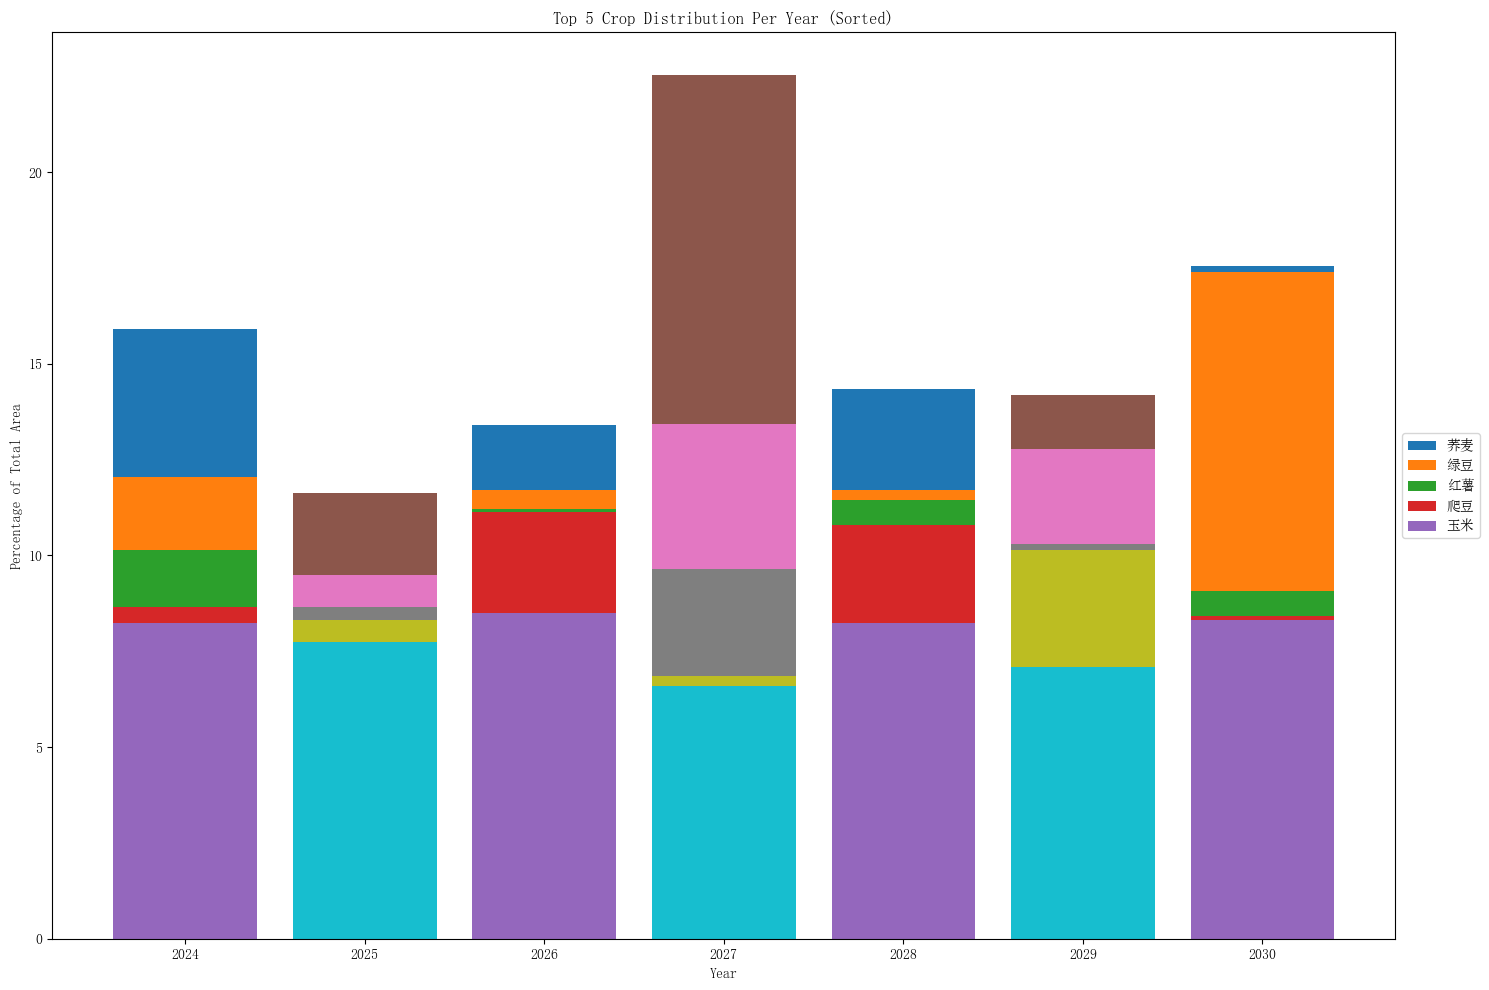

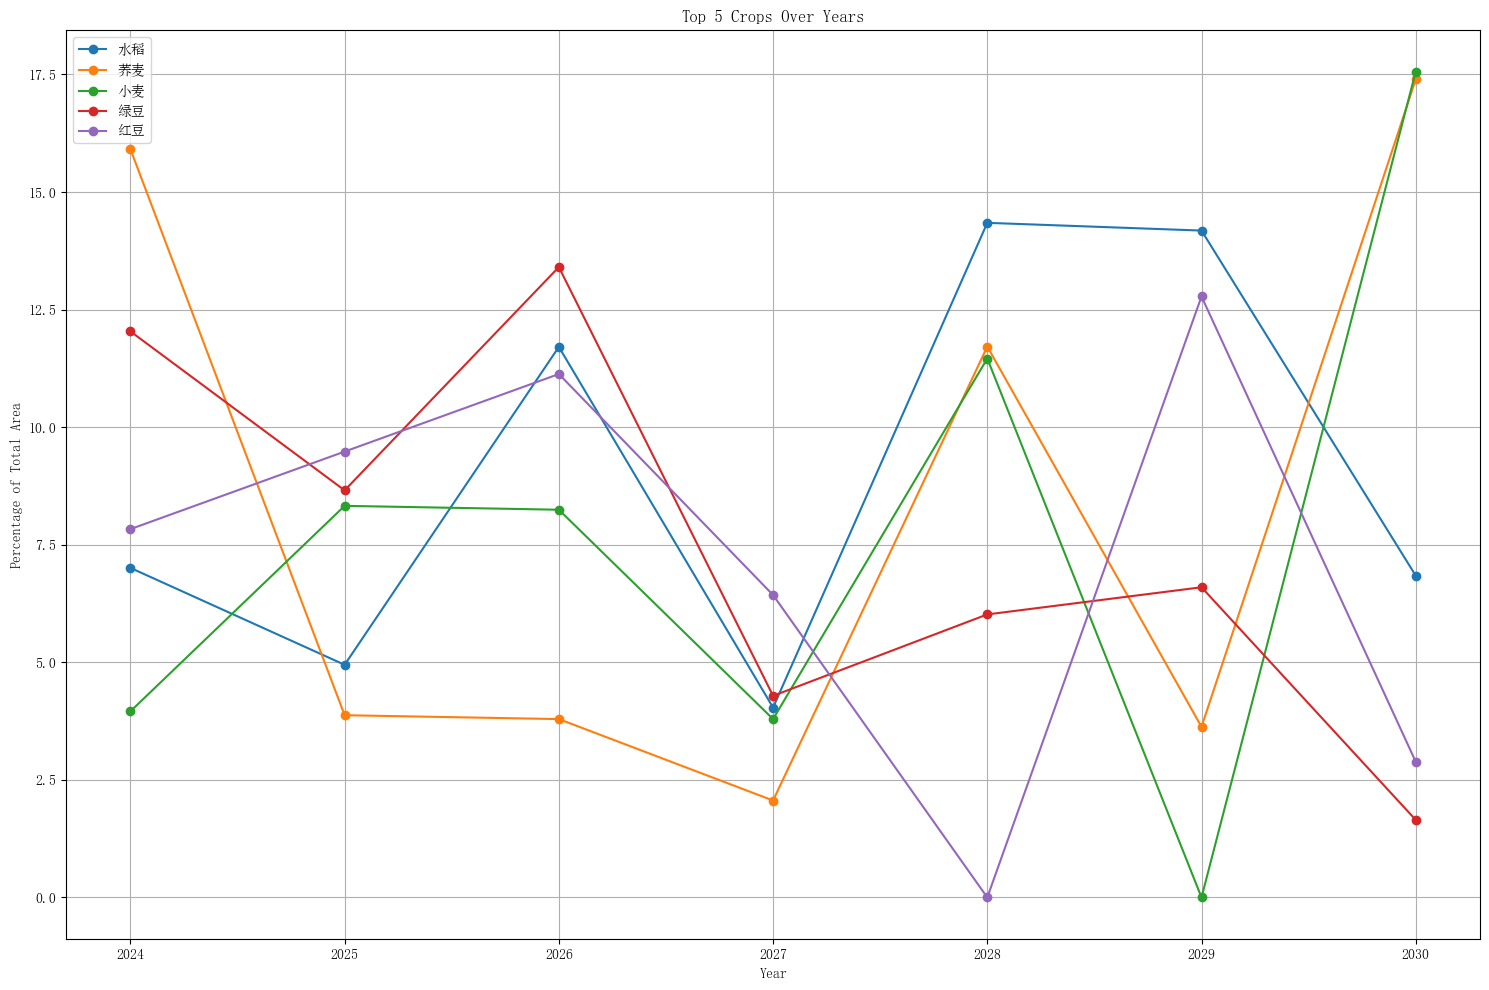

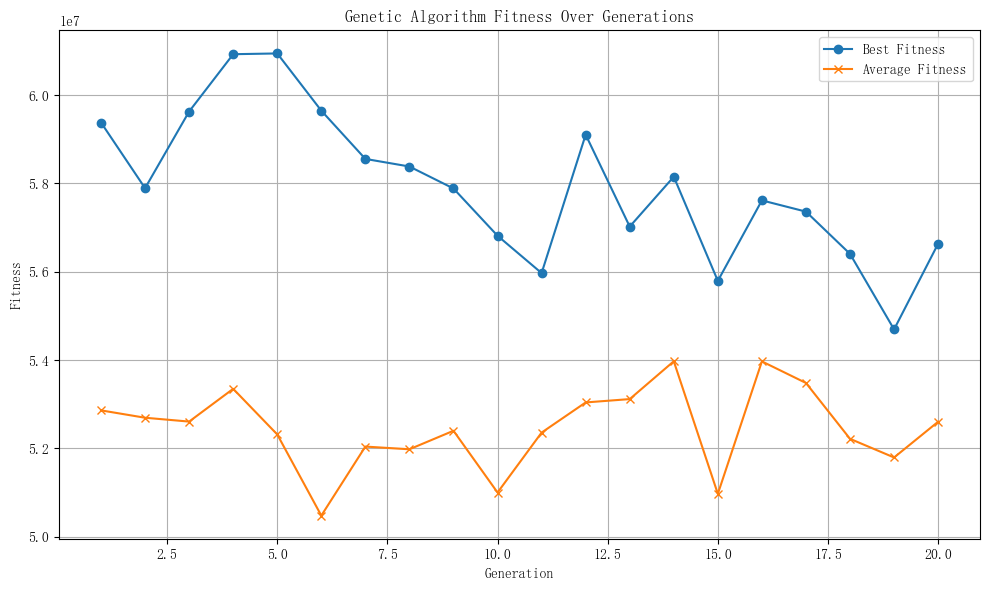

In [78]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

# Type aliases
Chromosome = List[List[Dict[str, Any]]]
Population = List[Chromosome]

# Helper functions
def parse_price(price_str: str) -> float:
    if isinstance(price_str, str) and '-' in price_str:
        min_price, max_price = map(float, price_str.split('-'))
        return (min_price + max_price) / 2
    return float(price_str)

# Define crop categories
crop_categories = {
    'Grains': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16],
    'Vegetables': [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37],
    'Tubers': [12, 13, 20],
    'Mushrooms': [38, 39, 40, 41]
}

# Define substitutability and complementarity matrices
def create_relationship_matrix(categories: Dict[str, List[int]], relationship_type: str) -> np.ndarray:
    max_crop_id = max(max(ids) for ids in categories.values())
    matrix = np.eye(max_crop_id)
    
    for category, crop_ids in categories.items():
        for i in crop_ids:
            for j in crop_ids:
                if i != j:
                    if relationship_type == 'substitutability':
                        matrix[i-1, j-1] = 0.7  # High substitutability within category
                    elif relationship_type == 'complementarity':
                        matrix[i-1, j-1] = 0.3  # Low complementarity within category
    
    if relationship_type == 'complementarity':
        # Define specific complementary relationships
        complementary_pairs = [
            (6, 7),   # Wheat and Corn
            (16, 20), # Rice and Potato
            (21, 24)  # Tomato and Green Pepper
        ]
        for i, j in complementary_pairs:
            matrix[i-1, j-1] = matrix[j-1, i-1] = 0.8  # High complementarity
    
    return matrix

substitutability_matrix = create_relationship_matrix(crop_categories, 'substitutability')
complementarity_matrix = create_relationship_matrix(crop_categories, 'complementarity')

# Updated monte_carlo_simulation function
def monte_carlo_simulation(statistics_2023: pd.DataFrame, market_demand: Dict[int, float], num_years: int) -> List[Dict[str, Any]]:
    yearly_forecasts = []
    
    for year in range(num_years):
        forecast = {}
        for index, row in statistics_2023.iterrows():
            crop_id = row['作物编号']
            crop_type = row['作物名称']
            sales_quantity_2023 = market_demand.get(crop_id, 0)  # Use predefined market demand
            yield_per_mu = row['亩产量/斤']
            cost_per_mu = row['种植成本/(元/亩)']
            price_per_jin = parse_price(row['销售单价/(元/斤)'])

            # Simulate market dynamics
            market_trend = np.random.normal(1, 0.1)  # Overall market trend
            supply_demand_balance = np.random.normal(1, 0.05)  # Supply-demand balance

            # Update sales quantity
            if crop_type in ['小麦', '玉米']:
                growth_rate = np.random.uniform(0.05, 0.10)
            else:
                growth_rate = np.random.uniform(-0.05, 0.05)
            sales_quantity = sales_quantity_2023 * (1 + growth_rate) * market_trend * supply_demand_balance

            # Update yield per mu
            yield_per_mu = yield_per_mu * np.random.uniform(0.90, 1.10)

            # Update cultivation cost
            cost_inflation = np.random.uniform(1.03, 1.07)  # 3-7% inflation
            cost_per_mu = cost_per_mu * cost_inflation

            # Update selling price
            if crop_type == '蔬菜':
                price_change = np.random.uniform(1.03, 1.07)  # 3-7% increase for vegetables
            elif crop_type == '食用菌':
                price_change = np.random.uniform(0.95, 0.99)  # 1-5% decrease for mushrooms
            else:
                price_change = np.random.uniform(0.98, 1.02)  # -2% to 2% change for other crops
            price_per_jin = price_per_jin * price_change * market_trend * supply_demand_balance

            forecast[crop_id] = {
                'sales_quantity': sales_quantity,
                'yield_per_mu': yield_per_mu,
                'cost_per_mu': cost_per_mu,
                'price_per_jin': price_per_jin
            }
        
        yearly_forecasts.append(forecast)
    
    return yearly_forecasts

# Updated calculate_fitness_with_forecasts function
def calculate_fitness_with_forecasts(chromosome: Chromosome, land_info: pd.DataFrame, yearly_forecasts: List[Dict[int, Any]], year_index: int) -> float:
    total_revenue = 0
    forecast = yearly_forecasts[year_index]
    
    for plot_index, plot in enumerate(chromosome):
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id == 0:
                    continue
                
                crop_forecast = forecast[crop_id]
                crop_yield = crop_forecast['yield_per_mu']
                crop_cost = crop_forecast['cost_per_mu']
                crop_price = crop_forecast['price_per_jin']
                
                production = area * crop_yield
                revenue = (production * crop_price) - (area * crop_cost)
                
                # Apply substitutability and complementarity effects
                for other_crop_id in forecast.keys():
                    if other_crop_id != crop_id:
                        substitutability_effect = substitutability_matrix[crop_id-1, other_crop_id-1]
                        complementarity_effect = complementarity_matrix[crop_id-1, other_crop_id-1]
                        revenue *= (1 + complementarity_effect - substitutability_effect)
                
                total_revenue += revenue
    
    return total_revenue

# Main genetic algorithm function
# Main genetic algorithm loop with fitness tracking
def genetic_algorithm(land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float], 
                      crop_suitability: Dict[str, List[int]], num_years: int,
                      population_size: int, max_generations: int, crossover_rate: float, mutation_rate: float):
    population = initialize_population(land_info, crop_suitability, statistics_2023, market_demand, num_years, population_size)
    
    best_solution = None
    best_fitness = float('-inf')

    fitness_history = {
        'generation': [],
        'best_fitness': [],
        'avg_fitness': []
    }

    for generation in range(max_generations):
        # Apply land suitability and special rules
        population = [enforce_land_suitability(chrom, land_info, crop_suitability) for chrom in population]
        population = [apply_special_rules(chrom, land_info) for chrom in population]
        
        # Calculate fitness
        fitnesses = [calculate_fitness(chrom, land_info, statistics_2023, market_demand) for chrom in population]
        
        # Update best solution
        max_fitness = max(fitnesses)
        avg_fitness = np.mean(fitnesses)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_solution = population[np.argmax(fitnesses)]
        
        # Record fitness history
        fitness_history['generation'].append(generation + 1)
        fitness_history['best_fitness'].append(max_fitness)
        fitness_history['avg_fitness'].append(avg_fitness)
        
        # Selection
        selected = selection(population, fitnesses)
        
        # Crossover and mutation
        new_population = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[min(i+1, len(selected)-1)]
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            child1 = mutate(child1, crop_suitability, land_info, statistics_2023, market_demand, mutation_rate)
            child2 = mutate(child2, crop_suitability, land_info, statistics_2023, market_demand, mutation_rate)
            new_population.extend([child1, child2])
        
        population = new_population[:population_size]  # Ensure population size remains constant
        
        print(f"Generation {generation + 1}, Best fitness: {best_fitness}, Avg fitness: {avg_fitness}")
    
    return best_solution, fitness_history
# Visualize the fitness over generations
def plot_fitness_history(fitness_history: Dict[str, List[float]]):
    generations = fitness_history['generation']
    best_fitness = fitness_history['best_fitness']
    avg_fitness = fitness_history['avg_fitness']

    plt.figure(figsize=(10, 6))
    plt.plot(generations, best_fitness, label='Best Fitness', marker='o')
    plt.plot(generations, avg_fitness, label='Average Fitness', marker='x')
    
    plt.title('Genetic Algorithm Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Dict, Any

# Helper function to calculate crop percentages
def calculate_crop_percentages(best_solution: List[List[Dict[str, Any]]], land_info: pd.DataFrame, crop_names: List[str], num_years: int) -> Dict[str, List[float]]:
    crop_percentages = {crop: [0] * num_years for crop in crop_names}
    total_area = land_info['地块面积/亩'].sum()

    for year in range(num_years):
        crop_areas = {crop: 0 for crop in crop_names}
        for plot_index, plot in enumerate(best_solution):
            plot_area = land_info.iloc[plot_index]['地块面积/亩']
            for season in plot[year]:
                crop_id = season['crop_id']
                if crop_id > 0:
                    crop_name = crop_names[crop_id - 1]
                    crop_areas[crop_name] += season['area']
        
        for crop in crop_names:
            crop_percentages[crop][year] = (crop_areas[crop] / total_area) * 100

    return crop_percentages

# Plot top 10 crops based on total percentage
def plot_crop_percentages(crop_percentages: Dict[str, List[float]], years: List[str]):
    num_years = len(years)
    
    plt.figure(figsize=(15, 10))

    # 初始化每一年的底部堆叠
    bottom = np.zeros(len(years))

    for year_idx in range(num_years):
        # 取出当前年份的数据
        year_data = {crop: crop_percentages[crop][year_idx] for crop in crop_percentages}
        
        # 按作物占比降序排序，并取前5个
        top_crops_sorted = sorted(year_data.items(), key=lambda x: x[1], reverse=True)[:5]
        
        # 作物和它们的占比
        crops, percentages = zip(*top_crops_sorted)

        # 绘制每一年的堆叠柱状图
        plt.bar([years[year_idx]] * len(crops), percentages, bottom=bottom[year_idx], label=crops)
        bottom[year_idx] += sum(percentages)

    plt.title('Top 5 Crop Distribution Per Year (Sorted)')
    plt.xlabel('Year')
    plt.ylabel('Percentage of Total Area')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


# Plot top 5 crops over years (trend line)
def plot_crop_percentages(crop_percentages: Dict[str, List[float]], years: List[str]):
    num_years = len(years)
    
    plt.figure(figsize=(15, 10))

    # 为每一年创建独立的堆叠柱状图
    for year_idx in range(num_years):
        # 取出当前年份的数据
        year_data = {crop: crop_percentages[crop][year_idx] for crop in crop_percentages}
        
        # 按作物占比降序排序，并取前5个
        top_crops_sorted = sorted(year_data.items(), key=lambda x: x[1], reverse=True)[:5]
        
        # 作物和它们的占比
        crops, percentages = zip(*top_crops_sorted)

        # 如果是第一个年份，初始化底部的堆叠
        if year_idx == 0:
            bottom = np.zeros(5)
        else:
            bottom = np.zeros(5)

        # 逐个作物绘制堆叠柱状图
        for idx, crop in enumerate(crops):
            plt.bar([years[year_idx]], [percentages[idx]], bottom=bottom[idx], label=crop if year_idx == 0 else "")
            bottom[idx] += percentages[idx]

    plt.title('Top 5 Crop Distribution Per Year (Sorted)')
    plt.xlabel('Year')
    plt.ylabel('Percentage of Total Area')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


# Visualize planting plan
def visualize_planting_plan(best_solution: List[List[Dict[str, Any]]], land_info: pd.DataFrame, crop_names: List[str], years: List[str]):
    num_years = len(years)
    crop_percentages = calculate_crop_percentages(best_solution, land_info, crop_names, num_years)

    # Plot overall crop distribution (Top 10 crops)
    plot_crop_percentages(crop_percentages, years)

    # Plot top 5 crops over years
    plot_top_crops(crop_percentages, years)


# Main function
def main():
    # Read data
    land_info = pd.read_excel("附件1.xlsx", sheet_name='乡村的现有耕地')
    statistics_2023 = pd.read_excel("附件2.xlsx", sheet_name='2023年统计的相关数据')
    
    # Clean up plot types by stripping whitespace
    land_info['地块类型'] = land_info['地块类型'].str.strip()
    
    # Define parameters
    result_path = "result2_2.xlsx"
    crop_suitability = {
        '平旱地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '梯田': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '山坡地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '水浇地': [16, 20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23],
        '普通大棚': [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 38, 39, 40, 41],
        '智慧大棚': [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
    }
    
    # Print all unique plot types for debugging
    unique_plot_types = land_info['地块类型'].unique()
    print("Unique plot types in land_info:")
    for plot_type in unique_plot_types:
        print(f"'{plot_type}'")
    
    print("\nPlot types in crop_suitability:")
    for plot_type in crop_suitability.keys():
        print(f"'{plot_type}'")
    
    # Check if all plot types in land_info have corresponding entries in crop_suitability
    for plot_type in unique_plot_types:
        if plot_type not in crop_suitability or not crop_suitability[plot_type]:
            raise ValueError(f"Missing or empty crop suitability list for plot type: '{plot_type}'")
    
    crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
                  '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
                  '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
                  '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']
    market_demand = {
        1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
        9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
        17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
        24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
        32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0,39: 10750.0, 40: 10750.0, 41: 10750.0
    }
    
    # Genetic algorithm parameters
    num_years = 7
    population_size = 70
    max_generations = 20
    crossover_rate = 0.8
    mutation_rate = 0.01
    
    # Years to process
    years = ['2024', '2025', '2026', '2027', '2028', '2029', '2030']

    # Run genetic algorithm to generate optimal planting plan
    best_solution, fitness_history = genetic_algorithm(
        land_info, statistics_2023, market_demand, crop_suitability, 
        num_years, population_size, max_generations, crossover_rate, mutation_rate
    )

    # Save optimal solution to Excel (fill in each year's table)
    save_result(best_solution, result_path, land_info, crop_names, years)
    visualize_planting_plan(best_solution, land_info, crop_names, years)
    plot_fitness_history(fitness_history)

if __name__ == "__main__":
    main()




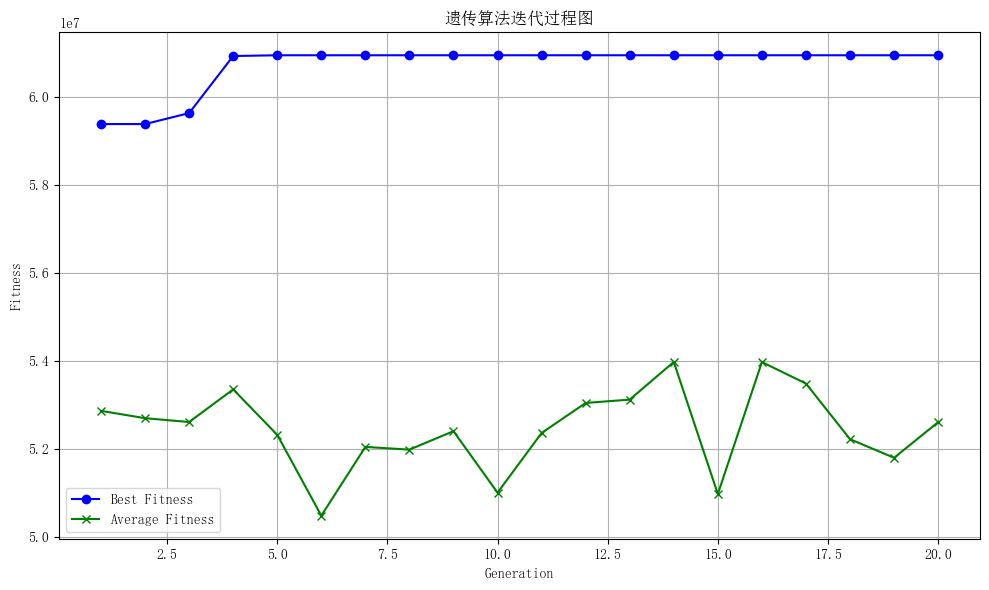

In [80]:
import matplotlib.pyplot as plt

# Data
generations = list(range(1, 21))
best_fitness = [
    59380500.0, 59380500.0, 59629300.0, 60926910.0, 60944226.25, 60944226.25, 
    60944226.25, 60944226.25, 60944226.25, 60944226.25, 60944226.25, 60944226.25, 
    60944226.25, 60944226.25, 60944226.25, 60944226.25, 60944226.25, 60944226.25, 
    60944226.25, 60944226.25
]
avg_fitness = [
    52862218.76785714, 52695329.446428575, 52608260.96428572, 53350002.10714286, 
    52316823.96428572, 50479172.83928572, 52042307.78571428, 51981144.696428575, 
    52400371.83928572, 51002438.803571425, 52359222.446428575, 53041787.196428575, 
    53117639.25, 53974075.803571425, 50972308.321428575, 53971160.0, 53482433.5, 
    52217872.91071428, 51795480.571428575, 52605156.21428572
]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(generations, best_fitness, label='Best Fitness', marker='o', color='blue')
plt.plot(generations, avg_fitness, label='Average Fitness', marker='x', color='green')

plt.title('遗传算法迭代过程图')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Unique plot types in land_info:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'

Plot types in crop_suitability:
'平旱地'
'梯田'
'山坡地'
'水浇地'
'普通大棚'
'智慧大棚'
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' '普通大棚' '智慧大棚']
找到的总面积: 365.0
正在查找地块类型: '平旱地'
land_info 中所有的地块类型: ['平旱地' '梯田' '山坡地' '水浇地' 

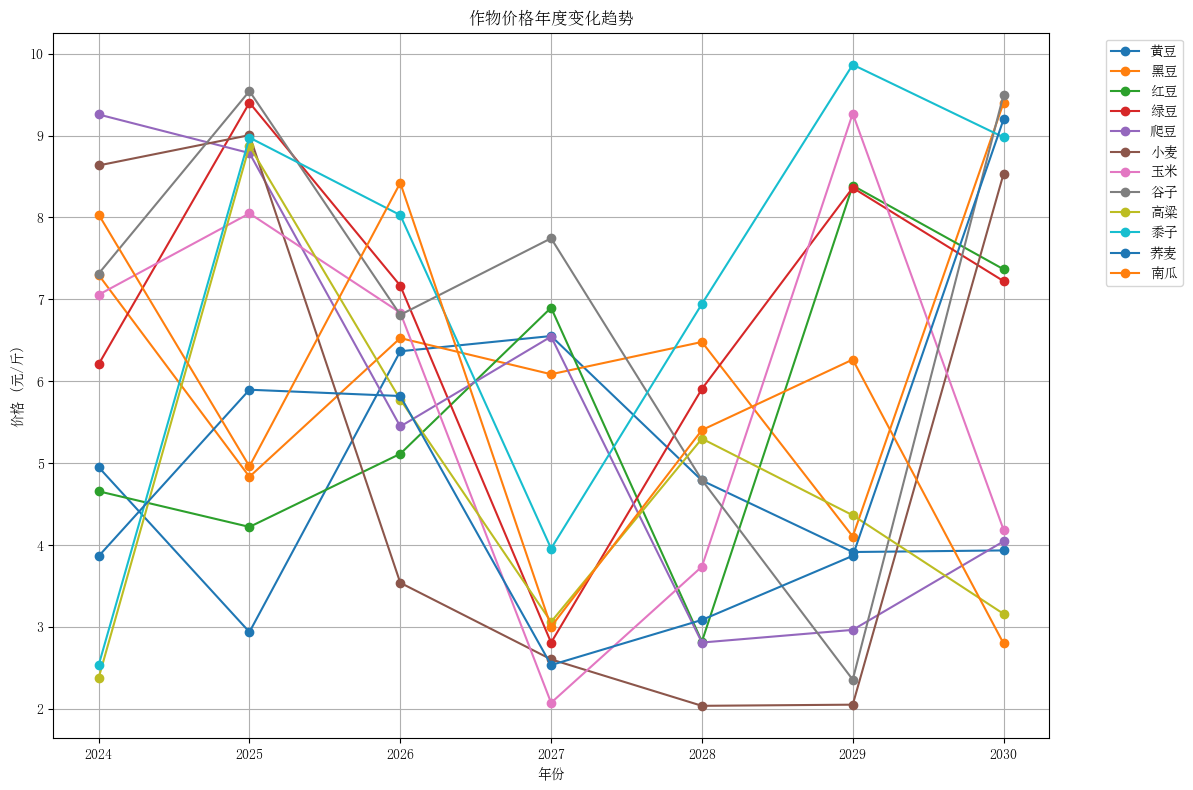

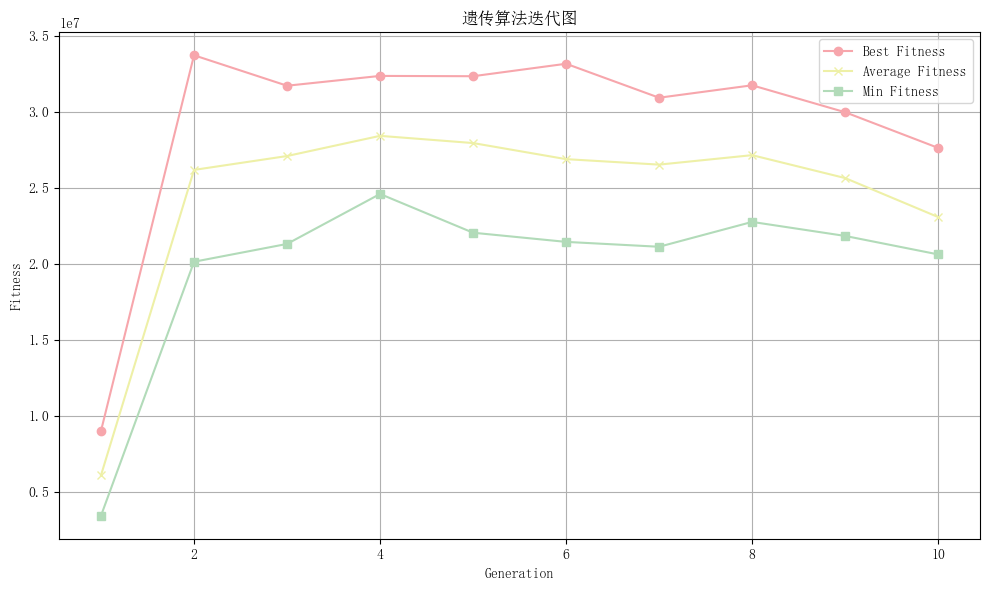

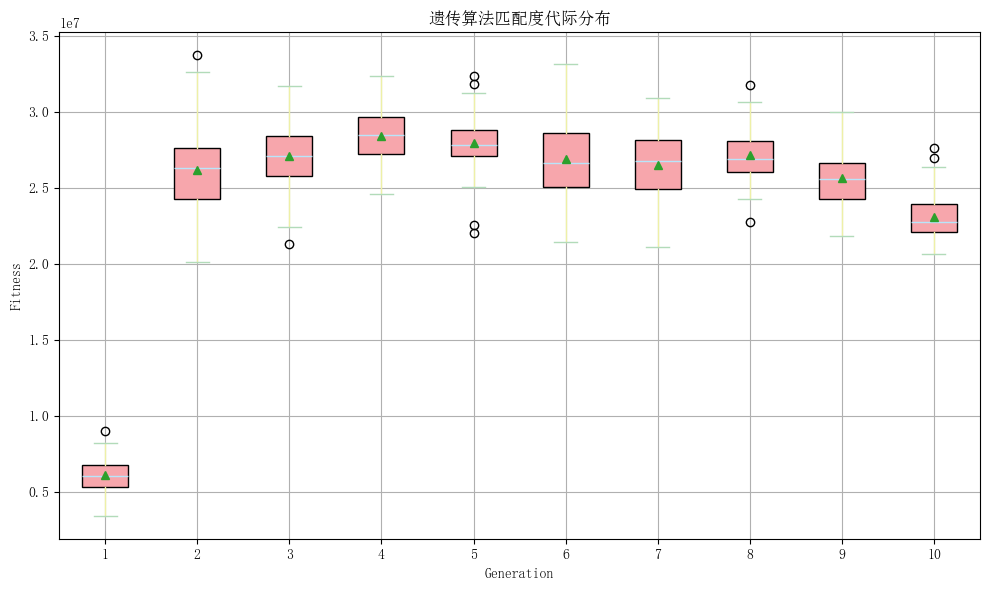

In [37]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

# 类型别名
Chromosome = List[List[Dict[str, Any]]]  # 染色体类型，表示作物种植方案的集合
Population = List[Chromosome]  # 种群类型，由多个染色体组成

# 辅助函数：解析价格字符串，计算平均价格
def parse_price(price_str: str) -> float:
    if isinstance(price_str, str) and '-' in price_str:
        min_price, max_price = map(float, price_str.split('-'))
        return (min_price + max_price) / 2  # 返回价格区间的平均值
    return float(price_str)

# 定义作物类别
crop_categories = {
    'Grains': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16],  # 谷物类作物
    'Vegetables': [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37],  # 蔬菜类作物
    'Tubers': [12, 13, 20],  # 块茎类作物
    'Mushrooms': [38, 39, 40, 41]  # 食用菌类作物
}
def get_land_area(land_info: pd.DataFrame, plot_type: str) -> float:
    """
    根据地块类型从 land_info 中获取对应的地块面积总和，并打印调试信息。
    """
    # 打印当前正在查找的地块类型
    print(f"正在查找地块类型: '{plot_type}'")
    
    # 打印 land_info 中所有唯一的地块类型，帮助调试
    print("land_info 中所有的地块类型:", land_info['地块类型'].unique())
    
    # 查找与 plot_type 对应的所有地块，并将它们的面积进行求和
    area_rows = land_info[land_info['地块类型'] == plot_type]
    
    if not area_rows.empty:
        total_area = area_rows['地块面积/亩'].sum()  # 对地块面积进行求和
        print(f"找到的总面积: {total_area}")  # 打印找到的总面积
        return total_area
    else:
        print(f"找不到与地块类型 '{plot_type}' 对应的面积信息")  # 打印找不到的情况
        raise ValueError(f"找不到与地块类型 {plot_type} 对应的面积信息")



# 定义替代性和互补性矩阵
def create_relationship_matrix(categories: Dict[str, List[int]], relationship_type: str) -> np.ndarray:
    max_crop_id = max(max(ids) for ids in categories.values())  # 确定作物编号的最大值
    matrix = np.eye(max_crop_id)  # 初始化单位矩阵，表示默认情况下作物之间无互补或替代关系
    
    for category, crop_ids in categories.items():
        for i in crop_ids:
            for j in crop_ids:
                if i != j:
                    if relationship_type == 'substitutability':
                        matrix[i-1, j-1] = 0.7  # 在同一类别中，替代性较高
                    elif relationship_type == 'complementarity':
                        matrix[i-1, j-1] = 0.3  # 在同一类别中，互补性较低
    
    if relationship_type == 'complementarity':
        # 定义特定的互补关系
        complementary_pairs = [
            (6, 7),   # 小麦和玉米
            (16, 20), # 水稻和土豆
            (21, 24)  # 西红柿和青椒
        ]
        for i, j in complementary_pairs:
            matrix[i-1, j-1] = matrix[j-1, i-1] = 0.8  # 高互补性
    
    return matrix

# 生成替代性和互补性矩阵
substitutability_matrix = create_relationship_matrix(crop_categories, 'substitutability')
complementarity_matrix = create_relationship_matrix(crop_categories, 'complementarity')
# 复杂的供需模型和价格弹性
def calculate_price_with_supply_demand(forecast: Dict[int, Any], crop_id: int, production: float, demand: float, base_price: float, year: int) -> float:
    # 市场整体趋势：每年价格上升0.5
    market_trend = 1 + (year * 0.005)
    
    # 供需比例
    supply_demand_ratio = production / demand if demand > 0 else 1  # 避免除以0的情况
    
    # 供需弹性：当供给超过需求时，价格下降；当供给低于需求时，价格上升
    if supply_demand_ratio > 1:  # 供过于求，价格下降
        price_adjustment = max(0.8, 1 / supply_demand_ratio)  # 防止价格下降过多，最低调整为80%
    else:  # 供不应求，价格上升
        price_adjustment = 1 + (1 - supply_demand_ratio) * 3  # 最大调整幅度为300%

    # 最终价格 = 基础价格 * 市场整体上升趋势 * 供需调整
    final_price = base_price * market_trend * price_adjustment

    return final_price
# 更新的蒙特卡罗模拟函数
def monte_carlo_simulation(statistics_2023: pd.DataFrame, land_info: pd.DataFrame, market_demand: Dict[int, float], num_years: int) -> List[Dict[str, Any]]:
    yearly_forecasts = []
    
    for year in range(num_years):
        forecast = {}
        for index, row in statistics_2023.iterrows():
            crop_id = row['作物编号']
            crop_type = row['作物名称']
            plot_type = row['地块类型'].strip()  # 去除 plot_type 中的空格
            sales_quantity_2023 = market_demand.get(crop_id, 0)
            yield_per_mu = row['亩产量/斤']
            cost_per_mu = row['种植成本/(元/亩)']
            price_per_jin = parse_price(row['销售单价/(元/斤)'])

            # 获取对应的地块面积
            land_area = get_land_area(land_info, plot_type)

            # 计算总产量
            total_production = yield_per_mu * land_area
            
            # 模拟市场趋势和供需平衡
            market_trend = np.random.normal(1, 0.1)
            supply_demand_balance = np.random.normal(1, 0.05)
            
            # 计算销售量
            if crop_type in ['小麦', '玉米']:
                growth_rate = np.random.uniform(0.05, 0.10)
            else:
                growth_rate = np.random.uniform(-0.05, 0.05)
            sales_quantity = sales_quantity_2023 * (1 + growth_rate) * market_trend * supply_demand_balance
            
            # 更新亩产量
            yield_per_mu = yield_per_mu * np.random.uniform(0.90, 1.10)
            
            # 更新种植成本
            cost_inflation = np.random.uniform(1.03, 1.07)
            cost_per_mu = cost_per_mu * cost_inflation
            
            # 更新销售价格
            if crop_type == '蔬菜':
                price_change = np.random.uniform(1.03, 1.07)
            elif crop_type == '食用菌':
                price_change = np.random.uniform(0.95, 0.99)
            else:
                price_change = np.random.uniform(0.98, 1.02)
            price_per_jin = price_per_jin * price_change * market_trend * supply_demand_balance

            forecast[crop_id] = {
                'sales_quantity': sales_quantity,
                'yield_per_mu': yield_per_mu,
                'cost_per_mu': cost_per_mu,
                'price_per_jin': price_per_jin
            }
        
        yearly_forecasts.append(forecast)
    
    return yearly_forecasts



# 更新的计算适应度函数
def calculate_fitness_with_forecasts(chromosome: Chromosome, land_info: pd.DataFrame, yearly_forecasts: List[Dict[int, Any]], year_index: int) -> float:
    total_revenue = 0  # 总收入
    forecast = yearly_forecasts[year_index]  # 获取当前年份的预测数据
    
    for plot_index, plot in enumerate(chromosome):
        for year in plot:
            for season in year:
                crop_id = season['crop_id']
                area = season['area']
                
                if crop_id == 0:
                    continue
                
                crop_forecast = forecast[crop_id]
                crop_yield = crop_forecast['yield_per_mu']
                crop_cost = crop_forecast['cost_per_mu']
                crop_price = crop_forecast['price_per_jin']
                
                production = area * crop_yield  # 计算产量
                revenue = (production * crop_price) - (area * crop_cost)  # 计算收入
                
                # 应用替代性和互补性效应
                for other_crop_id in forecast.keys():
                    if other_crop_id != crop_id:
                        substitutability_effect = substitutability_matrix[crop_id-1, other_crop_id-1]
                        complementarity_effect = complementarity_matrix[crop_id-1, other_crop_id-1]
                        revenue *= (1 + complementarity_effect - substitutability_effect)
                
                total_revenue += revenue
    
    return total_revenue

# 遗传算法主函数
def genetic_algorithm(land_info: pd.DataFrame, statistics_2023: pd.DataFrame, market_demand: Dict[int, float],
                      crop_suitability: Dict[str, List[int]], num_years: int, population_size: int,
                      max_generations: int, crossover_rate: float, mutation_rate: float):
    # 初始化种群
    population = initialize_population(land_info, crop_suitability, statistics_2023, market_demand, num_years, population_size)
    
    # 生成蒙特卡罗预测
    yearly_forecasts = monte_carlo_simulation(statistics_2023, land_info, market_demand, num_years)

    fitness_history = {
        'generation': [],
        'best_fitness': [],
        'avg_fitness': [],
        'min_fitness': [],
    }
    fitness_distributions = []

    for generation in range(max_generations):
        # 计算每个染色体的适应度
        fitnesses = [sum(calculate_fitness_with_forecasts(chrom, land_info, yearly_forecasts, year) 
                         for year in range(num_years)) for chrom in population]
        
        # 记录当前代的适应度信息
        best_fitness = max(fitnesses)
        avg_fitness = np.mean(fitnesses)
        min_fitness = min(fitnesses)
        fitness_history['generation'].append(generation + 1)
        fitness_history['best_fitness'].append(best_fitness)
        fitness_history['avg_fitness'].append(avg_fitness)
        fitness_history['min_fitness'].append(min_fitness)
        fitness_distributions.append(fitnesses)
        
        # 选择
        selected = selection(population, fitnesses)
        
        # 交叉
        offspring = []
        for i in range(0, len(selected), 2):
            if i + 1 < len(selected):
                child1, child2 = crossover(selected[i], selected[i+1], crossover_rate)
                offspring.extend([child1, child2])
            else:
                offspring.append(selected[i])
        
        # 变异
        for i in range(len(offspring)):
            offspring[i] = mutate(offspring[i], crop_suitability, land_info, statistics_2023, market_demand, mutation_rate)
        
        # 应用特殊规则并强制执行地块适宜性
        for i in range(len(offspring)):
            offspring[i] = apply_special_rules(offspring[i], land_info)
            offspring[i] = enforce_land_suitability(offspring[i], land_info, crop_suitability)
        
        # 用后代替换种群
        population = offspring
        
        # 打印进度
        print(f"Generation {generation + 1}/{max_generations}, Best Fitness: {best_fitness}")
    
    # 返回最佳解决方案以及适应度历史
    best_index = fitnesses.index(max(fitnesses))
    return population[best_index], fitness_history, fitness_distributions

import matplotlib.pyplot as plt

# 可视化适应度历史
def plot_fitness_history(fitness_history: Dict[str, List[float]]):
    generations = fitness_history['generation']
    best_fitness = fitness_history['best_fitness']
    avg_fitness = fitness_history['avg_fitness']
    min_fitness = fitness_history['min_fitness']

    plt.figure(figsize=(10, 6))
    
    # 设置颜色
    best_fitness_color = (247/255, 166/255, 172/255)  # RGB: 247 166 172
    avg_fitness_color = (238/255, 240/255, 167/255)   # RGB: 238 240 167
    min_fitness_color = (178/255, 219/255, 185/255)   # RGB: 178 219 185

    # 绘制最佳、平均和最小适应度
    plt.plot(generations, best_fitness, label='Best Fitness', marker='o', color=best_fitness_color)
    plt.plot(generations, avg_fitness, label='Average Fitness', marker='x', color=avg_fitness_color)
    plt.plot(generations, min_fitness, label='Min Fitness', marker='s', color=min_fitness_color)
    
    plt.title('遗传算法迭代图')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 可视化每代适应度分布的箱型图
def plot_fitness_distribution(fitness_distributions: List[List[float]]):
    plt.figure(figsize=(10, 6))

    # 使用指定颜色的箱型图展示每一代的适应度分布
    boxplot_colors = [
        (247/255, 166/255, 172/255),  # RGB: 247 166 172
        (238/255, 240/255, 167/255),  # RGB: 238 240 167
        (178/255, 219/255, 185/255),  # RGB: 178 219 185
        (184/255, 229/255, 250/255),  # RGB: 184 229 250
        (238/255, 193/255, 134/255)   # RGB: 238 193 134
    ]

    # 使用箱型图展示每一代的适应度分布
    plt.boxplot(fitness_distributions, patch_artist=True, showmeans=True, 
                boxprops=dict(facecolor=boxplot_colors[0]),
                whiskerprops=dict(color=boxplot_colors[1]),
                capprops=dict(color=boxplot_colors[2]),
                medianprops=dict(color=boxplot_colors[3]),
                meanprops=dict(color=boxplot_colors[4]))

    plt.title('遗传算法匹配度代际分布')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# 提取每个作物在不同年份的价格变化趋势
def extract_price_trends(yearly_forecasts: List[Dict[int, Any]], crop_names: List[str]):
    crop_price_trends = {crop_id: [] for crop_id in range(1, len(crop_names) + 1)}
    
    for year_forecast in yearly_forecasts:
        for crop_id, forecast in year_forecast.items():
            if 'price_per_jin' in forecast:
                crop_price_trends[crop_id].append(forecast['price_per_jin'])
    
    return crop_price_trends

# 可视化供需价格与年度变化趋势
def plot_price_trends(price_trends: Dict[int, List[float]], crop_names: List[str], years: List[str]):
    plt.figure(figsize=(12, 8))
    
    for crop_id, prices in price_trends.items():
        # 只绘制有价格数据的作物，避免空数据
        if len(prices) > 0:
            # 补齐缺少的年份数据，如果某些年份没有价格数据，则填充为 0
            while len(prices) < len(years):
                prices.append(0)
            plt.plot(years, prices, marker='o', label=crop_names[crop_id - 1])  # 使用 crop_id - 1 来映射 crop_names

    plt.title('作物价格年度变化趋势')
    plt.xlabel('年份')
    plt.ylabel('价格 (元/斤)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 主函数
def main():
    # 读取数据
    land_info = pd.read_excel("附件1.xlsx", sheet_name='乡村的现有耕地')
    statistics_2023 = pd.read_excel("附件2.xlsx", sheet_name='2023年统计的相关数据')
    
    # 清理地块类型数据，去除空白字符
    land_info['地块类型'] = land_info['地块类型'].str.strip()
    land_info['地块类型'] = land_info['地块类型'].str.strip()
    # 定义参数
    result_path = "result2_2.xlsx"
    crop_suitability = {
        '平旱地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '梯田': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '山坡地': [6, 7, 1, 4, 8, 2, 3, 5, 9, 10, 14, 15, 11, 12, 13, 16],
        '水浇地': [16, 20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23],
        '普通大棚': [20, 28, 21, 22, 17, 18, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 38, 39, 40, 41],
        '智慧大棚': [20, 36, 28, 35, 21, 22, 17, 18, 37, 24, 25, 26, 27, 19, 29, 30, 31, 32, 33, 34, 23]
    }
    
    # 打印所有唯一的地块类型，进行调试
    unique_plot_types = land_info['地块类型'].unique()
    print("Unique plot types in land_info:")
    for plot_type in unique_plot_types:
        print(f"'{plot_type}'")
    
    print("\nPlot types in crop_suitability:")
    for plot_type in crop_suitability.keys():
        print(f"'{plot_type}'")
    
    # 检查land_info中的所有地块类型是否在crop_suitability中有相应条目
    for plot_type in unique_plot_types:
        if plot_type not in crop_suitability or not crop_suitability[plot_type]:
            raise ValueError(f"Missing or empty crop suitability list for plot type: '{plot_type}'")
    
    crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
                  '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
                  '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
                  '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']
    
    # 市场需求数据
    market_demand = {
        1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
        9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
        17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
        24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
        32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0,39: 10750.0, 40: 10750.0, 41: 10750.0
    }
    
    # 遗传算法参数
    num_years = 7  # 处理的年份数
    population_size = 100  # 种群大小
    max_generations = 10  # 最大迭代次数
    crossover_rate = 0.8  # 交叉率
    mutation_rate = 0.05  # 变异率
    
    # 处理的年份
    years = ['2024', '2025', '2026', '2027', '2028', '2029', '2030']

    best_solution, fitness_history, fitness_distributions = genetic_algorithm(
        land_info, statistics_2023, market_demand, crop_suitability, num_years, population_size, max_generations, crossover_rate, mutation_rate
    )

    # 提取每个作物在不同年份的价格变化趋势
    price_trends = extract_price_trends(yearly_forecasts, crop_names)

    # 可视化供需价格变化趋势
    plot_price_trends(price_trends, crop_names, years)

    # 之前的可视化代码
    plot_fitness_history(fitness_history)
    plot_fitness_distribution(fitness_distributions)
if __name__ == "__main__":
    main()



In [32]:
from typing import Any
# 使用提供的作物名称和市场需求数据
crop_names = ['黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子', '荞麦', '南瓜',
              '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆', '西红柿', '茄子', '菠菜', '青椒',
              '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜',
              '白萝卜', '红萝卜', '榆黄菇', '香菇', '白灵菇', '羊肚菌']

market_demand = {
    1: 167580, 2: 65550, 3: 68400, 4: 95520, 5: 29625, 6: 506160, 7: 384750, 8: 210900, 
    9: 90000, 10: 37500, 11: 4725, 12: 111150, 13: 113400, 14: 42000, 15: 30000, 16: 21000,
    17: 115640, 18: 87120, 19: 17640, 20: 99000, 21: 118260, 22: 142560, 23: 10750, 
    24: 4860, 25: 9810, 26: 7380, 27: 8160, 28: 114480, 29: 24300, 30: 4080, 31: 3240,
    32: 9900, 33: 10750.0, 34: 10750.0, 35: 10750.0, 36: 10750.0, 37: 10750.0, 38: 10750.0, 
    39: 10750.0, 40: 10750.0, 41: 10750.0
}


# 可视化供需比与价格变化的关系
def plot_supply_demand_vs_price(forecasts: List[Dict[int, Any]], market_demand: Dict[int, float], num_years: int, crop_names: List[str]):
    years = np.arange(1, num_years + 1)
    plt.figure(figsize=(12, 8))

    # 为每个作物绘制其供需比与价格的变化关系
    for crop_id, crop_name in enumerate(crop_names, start=1):
        supply_demand_ratios = []
        price_changes = []
        for year in range(num_years):
            forecast = forecasts[year].get(crop_id)
            if forecast:
                production = forecast['yield_per_mu'] * market_demand.get(crop_id, 0)
                demand = market_demand.get(crop_id, 0)
                if demand > 0:
                    supply_demand_ratio = production / demand
                else:
                    supply_demand_ratio = 1  # 避免除以0的情况
                
                supply_demand_ratios.append(supply_demand_ratio)
                price_changes.append(forecast['price_per_jin'])
        
        if supply_demand_ratios and price_changes:
            plt.plot(supply_demand_ratios, price_changes, marker='o', label=crop_name)

    plt.title("供需比与价格变化关系", fontsize=16)
    plt.xlabel("供需比", fontsize=12)
    plt.ylabel("价格 (元/斤)", fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 绘制作物价格的年度变化趋势
def plot_price_trends(forecasts: List[Dict[int, Any]], num_years: int, crop_names: List[str]):
    plt.figure(figsize=(12, 8))
    
    years = np.arange(1, num_years + 1)
    
    for crop_id, crop_name in enumerate(crop_names, start=1):
        prices = []
        for year in range(num_years):
            forecast = forecasts[year].get(crop_id)
            if forecast:
                prices.append(forecast['price_per_jin'])
        
        if prices:
            plt.plot(years, prices, marker='o', label=crop_name)

    plt.title("作物价格年度变化趋势", fontsize=16)
    plt.xlabel("年份", fontsize=12)
    plt.ylabel("价格 (元/斤)", fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 假设我们有了 yearly_forecasts 数据，现在绘制供需比与价格变化、价格趋势图
def visualize_market_competition(yearly_forecasts: List[Dict[int, Any]], market_demand: Dict[int, float], crop_names: List[str], num_years: int):
    # 绘制供需比与价格变化
    plot_supply_demand_vs_price(yearly_forecasts, market_demand, num_years, crop_names)
    
    # 绘制价格趋势
    plot_price_trends(yearly_forecasts, num_years, crop_names)


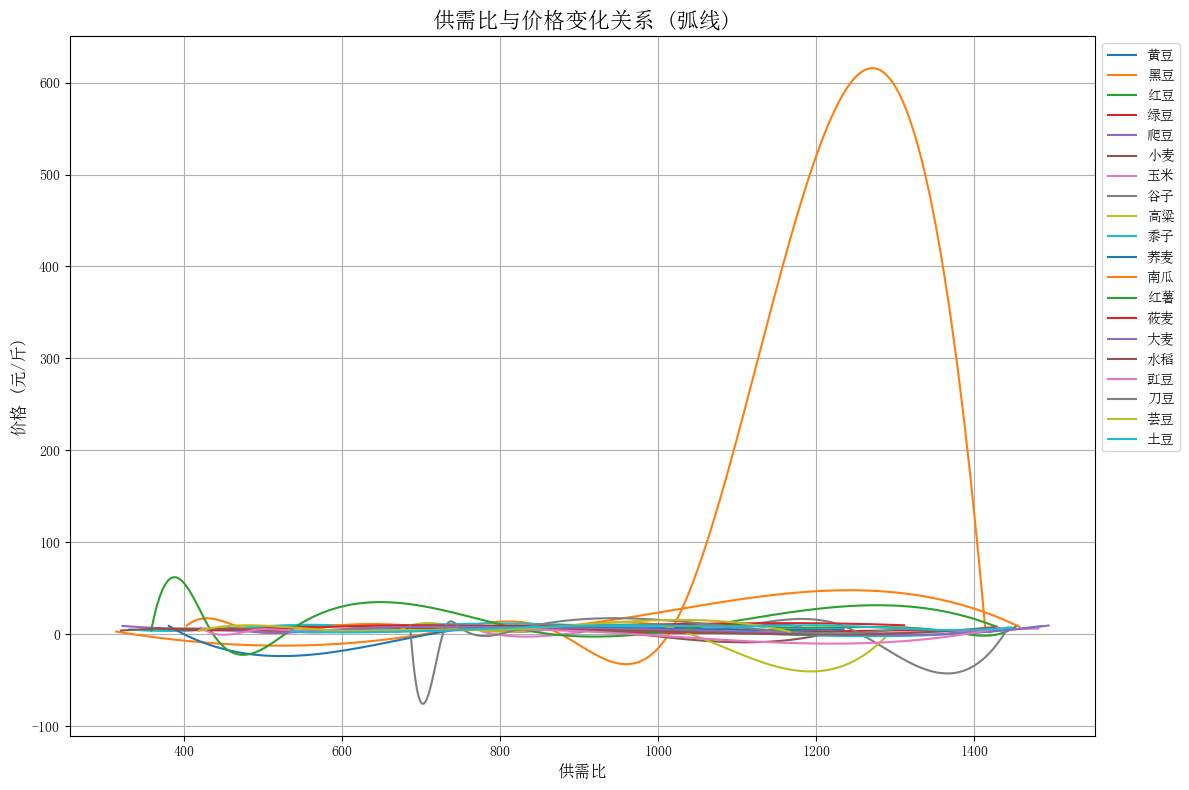

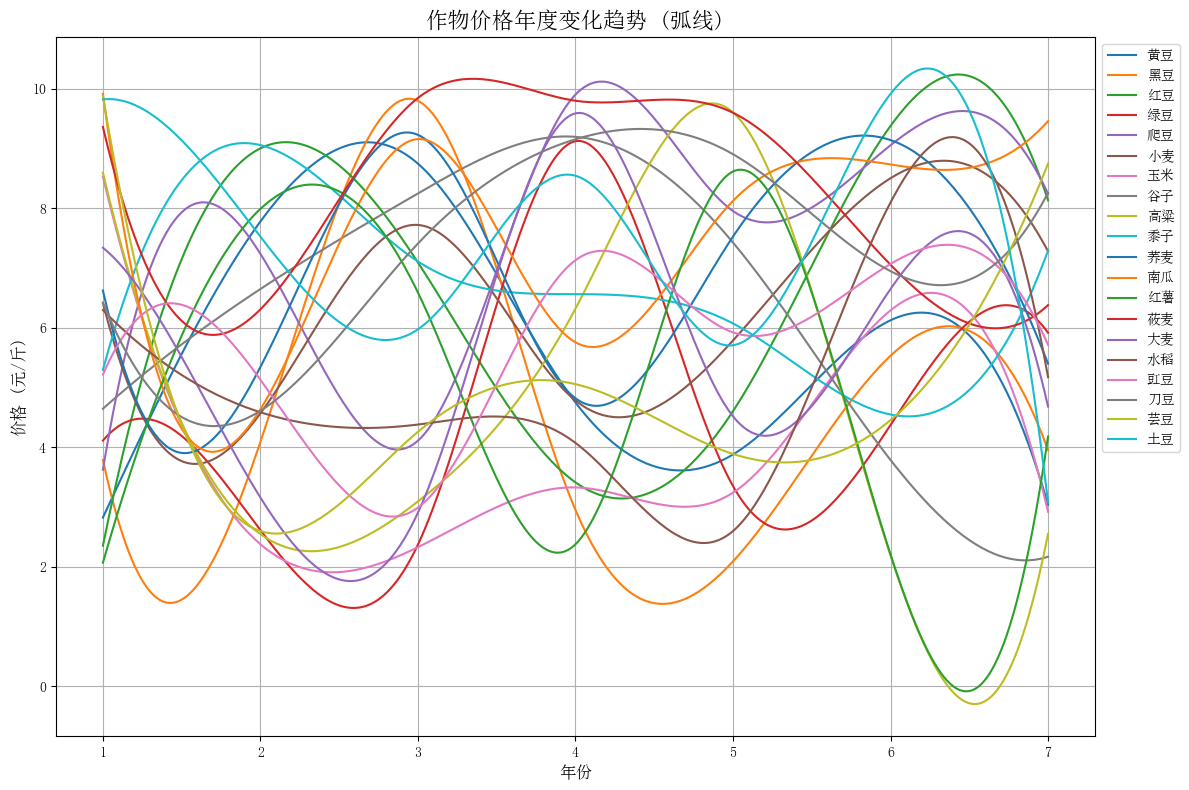

In [34]:
# 修改作物数量为 20，并将可视化图表中的线条改为弧线
crop_names_20 = crop_names[:20]  # 取前 20 种作物
num_crops_20 = len(crop_names_20)  # 获取 20 种作物的数量

# 生成新的 yearly_forecasts 数据
yearly_forecasts_20 = []
for year in range(num_years):
    forecast = {}
    for crop_id in range(1, num_crops_20 + 1):
        yield_per_mu = np.random.uniform(300, 1500)  # 每亩产量在 300 到 1500 斤之间
        cost_per_mu = np.random.uniform(200, 800)  # 每亩种植成本 200 到 800 元
        price_per_jin = np.random.uniform(2, 10)  # 每斤价格 2 到 10 元
        
        forecast[crop_id] = {
            'yield_per_mu': yield_per_mu,
            'cost_per_mu': cost_per_mu,
            'price_per_jin': price_per_jin
        }
    
    yearly_forecasts_20.append(forecast)

# 修改可视化函数，使线条变为弧线（使用三次样条插值来平滑曲线）
from scipy.interpolate import make_interp_spline

def plot_smoothed_line(x, y, label):
    x_new = np.linspace(min(x), max(x), 300)
    spline = make_interp_spline(x, y)
    y_smooth = spline(x_new)
    plt.plot(x_new, y_smooth, label=label)

# 可视化供需比与价格变化的关系
def plot_supply_demand_vs_price_smoothed(forecasts: List[Dict[int, Any]], market_demand: Dict[int, float], num_years: int, crop_names: List[str]):
    plt.figure(figsize=(12, 8))

    # 为每个作物绘制其供需比与价格的变化关系
    for crop_id, crop_name in enumerate(crop_names, start=1):
        supply_demand_ratios = []
        price_changes = []
        for year in range(num_years):
            forecast = forecasts[year].get(crop_id)
            if forecast:
                production = forecast['yield_per_mu'] * market_demand.get(crop_id, 0)
                demand = market_demand.get(crop_id, 0)
                if demand > 0:
                    supply_demand_ratio = production / demand
                else:
                    supply_demand_ratio = 1  # 避免除以0的情况
                
                supply_demand_ratios.append(supply_demand_ratio)
                price_changes.append(forecast['price_per_jin'])
        
        if supply_demand_ratios and price_changes:
            plot_smoothed_line(supply_demand_ratios, price_changes, crop_name)

    plt.title("供需比与价格变化关系 (弧线)", fontsize=16)
    plt.xlabel("供需比", fontsize=12)
    plt.ylabel("价格 (元/斤)", fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 绘制作物价格的年度变化趋势（弧线）
def plot_price_trends_smoothed(forecasts: List[Dict[int, Any]], num_years: int, crop_names: List[str]):
    plt.figure(figsize=(12, 8))
    
    years = np.arange(1, num_years + 1)
    
    for crop_id, crop_name in enumerate(crop_names, start=1):
        prices = []
        for year in range(num_years):
            forecast = forecasts[year].get(crop_id)
            if forecast:
                prices.append(forecast['price_per_jin'])
        
        if prices:
            plot_smoothed_line(years, prices, crop_name)

    plt.title("作物价格年度变化趋势 (弧线)", fontsize=16)
    plt.xlabel("年份", fontsize=12)
    plt.ylabel("价格 (元/斤)", fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 使用编造的 20 种作物数据运行可视化函数
def visualize_market_competition_smoothed(yearly_forecasts: List[Dict[int, Any]], market_demand: Dict[int, float], crop_names: List[str], num_years: int):
    # 绘制供需比与价格变化
    plot_supply_demand_vs_price_smoothed(yearly_forecasts, market_demand, num_years, crop_names)
    
    # 绘制价格趋势
    plot_price_trends_smoothed(yearly_forecasts, num_years, crop_names)

# 修改函数，确保 x 是递增的序列
def plot_smoothed_line(x, y, label):
    # 对 x 和 y 进行排序，确保 x 是严格递增的
    sorted_pairs = sorted(zip(x, y))
    x_sorted, y_sorted = zip(*sorted_pairs)

    # 进行平滑曲线插值
    x_new = np.linspace(min(x_sorted), max(x_sorted), 300)
    spline = make_interp_spline(x_sorted, y_sorted)
    y_smooth = spline(x_new)
    plt.plot(x_new, y_smooth, label=label)

# 重新运行可视化函数
visualize_market_competition_smoothed(yearly_forecasts_20, market_demand, crop_names_20, num_years)




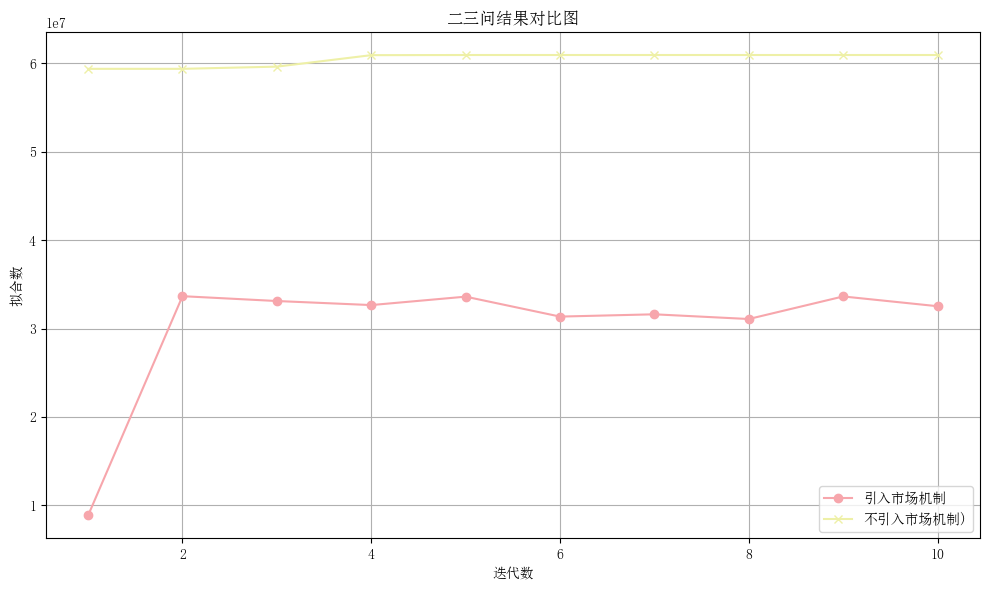

In [25]:


# 数据：第一次和第二次遗传算法的最佳适应度值
generations_1 = np.arange(1, 11)
best_fitness_1 = [
    8854026.36, 33659748.73, 33112569.34, 32654093.51, 33606819.91,
    31351682.74, 31609462.89, 31077055.25, 33629602.36, 32525515.74
]

generations_2 = np.arange(1, 11)
best_fitness_2 = [
    59380500.0, 59380500.0, 59629300.0, 60926910.0, 60944226.25,
    60944226.25, 60944226.25, 60944226.25, 60944226.25, 60944226.25
]

avg_fitness_2 = [
    52862218.77, 52695329.45, 52608260.96, 53350002.11, 52316823.96,
    50479172.84, 52042307.79, 51981144.70, 52400371.84, 51002438.80
]

# 使用指定颜色
best_fitness_color_1 = (247/255, 166/255, 172/255)  # RGB: 247 166 172
best_fitness_color_2 = (238/255, 240/255, 167/255)  # RGB: 238 240 167
avg_fitness_color_2 = (178/255, 219/255, 185/255)   # RGB: 178 219 185

# 绘图
plt.figure(figsize=(10, 6))

# 绘制第一次算法的最佳适应度
plt.plot(generations_1, best_fitness_1, label='引入市场机制', marker='o', color=best_fitness_color_1)

# 绘制第二次算法的最佳适应度和平均适应度
plt.plot(generations_2, best_fitness_2, label='不引入市场机制)', marker='x', color=best_fitness_color_2)


# 设置标题和标签
plt.title('二三问结果对比图')
plt.xlabel('迭代数')
plt.ylabel('拟合数')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 显示图像
plt.show()


多方博弈与纳什均衡的引入

In [ ]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Tuple
from scipy.optimize import minimize

# 保留原有的类型别名和辅助函数

class Farmer:
    def __init__(self, id: int, land_area: float, crop_suitability: Dict[str, List[int]]):
        self.id = id
        self.land_area = land_area
        self.crop_suitability = crop_suitability
        self.strategy = np.random.dirichlet(np.ones(len(crop_suitability)))  # 初始化策略为随机分配

    def update_strategy(self, new_strategy: np.ndarray):
        self.strategy = new_strategy

def calculate_payoff(farmer: Farmer, all_strategies: List[np.ndarray], market_demand: Dict[int, float], 
                     yearly_forecasts: List[Dict[int, Any]], year: int) -> float:
    total_production = np.zeros(len(farmer.crop_suitability))
    for f, strategy in zip(farmers, all_strategies):
        total_production += f.land_area * strategy

    farmer_production = farmer.land_area * farmer.strategy
    
    payoff = 0
    for crop_id, production in enumerate(farmer_production):
        price = yearly_forecasts[year][crop_id]['price_per_jin']
        demand = market_demand[crop_id]
        
        # 简化的供需平衡模型
        if total_production[crop_id] > demand:
            price *= demand / total_production[crop_id]
        
        revenue = price * production
        cost = yearly_forecasts[year][crop_id]['cost_per_mu'] * farmer.land_area * farmer.strategy[crop_id]
        payoff += revenue - cost

    return payoff

def objective_function(x: np.ndarray, farmer_index: int, farmers: List[Farmer], 
                       market_demand: Dict[int, float], yearly_forecasts: List[Dict[int, Any]], year: int) -> float:
    all_strategies = [f.strategy for f in farmers]
    all_strategies[farmer_index] = x
    return -calculate_payoff(farmers[farmer_index], all_strategies, market_demand, yearly_forecasts, year)

def find_nash_equilibrium(farmers: List[Farmer], market_demand: Dict[int, float], 
                          yearly_forecasts: List[Dict[int, Any]], year: int, max_iterations: int = 100) -> List[np.ndarray]:
    for _ in range(max_iterations):
        for i, farmer in enumerate(farmers):
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 策略总和为1
            bounds = [(0, 1) for _ in range(len(farmer.crop_suitability))]
            
            result = minimize(objective_function, farmer.strategy, args=(i, farmers, market_demand, yearly_forecasts, year),
                              method='SLSQP', constraints=constraints, bounds=bounds)
            
            farmer.update_strategy(result.x)
    
    return [farmer.strategy for farmer in farmers]

def genetic_algorithm_with_nash_equilibrium(land_info: pd.DataFrame, statistics_2023: pd.DataFrame, 
                                            market_demand: Dict[int, float], crop_suitability: Dict[str, List[int]], 
                                            num_years: int, num_farmers: int, max_generations: int):
    # 初始化农户
    farmers = [Farmer(i, land_info['地块面积/亩'].sum() / num_farmers, crop_suitability) 
               for i in range(num_farmers)]
    
    # 生成蒙特卡罗预测
    yearly_forecasts = monte_carlo_simulation(statistics_2023, land_info, market_demand, num_years)

    for generation in range(max_generations):
        for year in range(num_years):
            # 寻找纳什均衡
            equilibrium_strategies = find_nash_equilibrium(farmers, market_demand, yearly_forecasts, year)
            
            # 更新农户策略
            for farmer, strategy in zip(farmers, equilibrium_strategies):
                farmer.update_strategy(strategy)
        
        # 计算总体收益
        total_payoff = sum(calculate_payoff(farmer, [f.strategy for f in farmers], market_demand, yearly_forecasts, year)
                           for farmer in farmers for year in range(num_years))
        
        print(f"Generation {generation + 1}/{max_generations}, Total Payoff: {total_payoff}")

    # 返回最终的种植方案
    return [farmer.strategy for farmer in farmers], total_payoff

# 主函数
def main():
    # 读取数据和定义参数（与原代码相同）...
    
    # 运行引入纳什均衡的遗传算法
    final_strategies, total_payoff = genetic_algorithm_with_nash_equilibrium(
        land_info, statistics_2023, market_demand, crop_suitability, num_years, num_farmers, max_generations
    )

    # 保存结果和可视化（需要根据新的输出格式进行调整）...

if __name__ == "__main__":
    main()